In [100]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore FutureWarnings from KMeans algorithm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Check out our data

In [101]:
print("Shape of train data:", train_data.shape)
print("Shape of test data:", test_data.shape)

Shape of train data: (891, 12)
Shape of test data: (418, 11)


In [102]:
print("Train dataframe:")
print(train_data.head())

print("\nTest dataframe:")
print(test_data.head())

Train dataframe:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   

Check our data for missing values

In [103]:
print("Missing values in train dataframe:")
print(train_data.isnull().sum())

print("\nMissing values in test dataframe:")
print(test_data.isnull().sum())

Missing values in train dataframe:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values in test dataframe:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


As we can see, there are some missing values in both the train and test dataframes. In the train dataframe, there are missing values in the 'Age', 'Cabin' and 'Embarked' columns, while in the test dataframe, there are missing values in the 'Age', 'Fare' and 'Cabin' columns. We need to handle these missing values before proceeding with clusterization.
First, let's handle the missing values in the 'Age' column of both dataframes. We can fill these missing values with the median age. 

In [104]:
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

Next, let's handle the missing values in the 'Fare' column of the test dataframe. We can fill these missing values with the median fare of the test dataframe. 

In [105]:
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

Now, let's handle the missing values in the 'Cabin' column of both dataframes. There are too many missing values in this column, so it may not be appropriate to fill in all of them. Instead, we can create a new column called 'CabinBool' which will indicate whether a passenger had a cabin or not, and drop the 'Cabin' column.

In [106]:
from numpy import int64


train_data['CabinBool'] = train_data['Cabin'].notna().astype(int64)
train_data.drop('Cabin', axis=1, inplace=True)

test_data['CabinBool'] = test_data['Cabin'].notna().astype(int64)
test_data.drop('Cabin', axis=1, inplace=True)

Finally, let's handle the missing values in the 'Embarked' column of the train dataframe. There are only two missing values in this column, so we can fill them with the mode value

In [107]:
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

For clustering, it's better to have numerical data instead of categorical data. So we will use one-hot encoding do encode our categorical features. 

However, before we proceed with one-hot encoding, we should first remove the columns that we won't be using.
From the train and test dataframes, we can see that the "Name", "Ticket", and "PassengerId" columns are unlikely to be useful for clustering, so we can remove them. Also we can remove "Survived" column, as it is target column used for supervised learning.

In [108]:
train_data.drop(['Name', 'Ticket', 'PassengerId', 'Survived'], axis=1, inplace=True)
test_data.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [109]:
print("Feature data types in the datasets:")
print(train_data.dtypes)

Feature data types in the datasets:
Pclass         int64
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Embarked      object
CabinBool      int64
dtype: object


Now we define a list of categorical columns to be one-hot encoded and encode them using pandas funtion for one-hot encoding.

In [110]:
cat_cols = ['Sex', 'Embarked']

train_data = pd.get_dummies(train_data, columns=cat_cols)
test_data = pd.get_dummies(test_data, columns=cat_cols)

We will use the silhouette score which measures the quality of clustering and ranges between -1 and 1, where a score closer to 1 indicates better clustering. 

Also we will show feature's mean values within a cluster to see what makes most impact.

In [111]:
def cluster_data(data, algorithm, n_clusters=2, eps=0.1, min_s=2):
    if algorithm == 'KMeans':
        cluster_model = KMeans(n_clusters=n_clusters, random_state=23)
    elif algorithm == 'DBSCAN':
        cluster_model = DBSCAN(eps=eps, min_samples=min_s)
    else:
        raise ValueError('Invalid algorithm specified')

    cluster_model.fit(data)
    labels = cluster_model.labels_
    score = silhouette_score(data, labels, metric='euclidean')

    if algorithm == 'KMeans':
        print(f"Silhouette Score for {algorithm} algorithm with {n_clusters} clusters: {score:.3f}\n")
        
    elif algorithm == 'DBSCAN':
        print(f"Silhouette Score for {algorithm} algorithm with {eps} eps and {min_s} min samples: {score:.3f}\n")

    print("Clusters grouping data\n",data.groupby(cluster_model.labels_).mean())

    return labels

We will use PCA (Principal component analysis) to reduce dimensionality.

In [112]:
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_data)

KMeans clustering

Silhouette Score for KMeans algorithm with 2 clusters: 0.791

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  2.391408  29.221062  0.514320  0.349642   22.411942   0.192124    0.334129   
1  1.000000  31.583396  0.660377  0.886792  187.032858   0.811321    0.641509   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.665871    0.165871    0.091885    0.742243  
1  0.358491    0.547170    0.000000    0.452830  


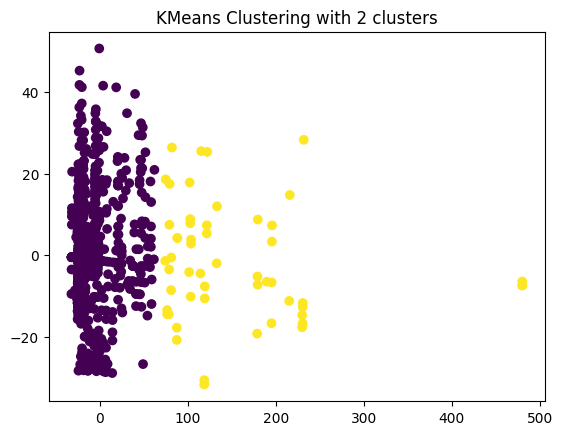

Silhouette Score for KMeans algorithm with 3 clusters: 0.662

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  2.551440  28.278807  0.429355  0.344307   15.453954   0.112483    0.311385   
1  1.000000  30.850000  0.750000  1.050000  279.308545   0.850000    0.600000   
2  1.246479  34.710704  0.971831  0.478873   83.393280   0.739437    0.528169   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.688615    0.145405    0.102881    0.751715  
1  0.400000    0.600000    0.000000    0.400000  
2  0.471831    0.352113    0.014085    0.633803  


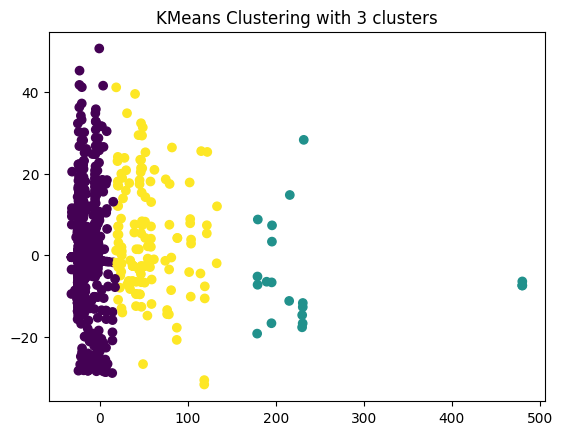

Silhouette Score for KMeans algorithm with 4 clusters: 0.648

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  2.557241  28.273448  0.430345  0.335172   15.273005   0.110345    0.308966   
1  1.274074  34.800000  0.992593  0.481481   76.633240   0.725926    0.511111   
2  1.000000  35.333333  0.000000  0.333333  512.329200   0.666667    0.333333   
3  1.000000  30.675714  0.714286  1.107143  204.948064   0.857143    0.714286   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.691034    0.143448    0.103448    0.753103  
1  0.488889    0.370370    0.014815    0.614815  
2  0.666667    1.000000    0.000000    0.000000  
3  0.285714    0.392857    0.000000    0.607143  


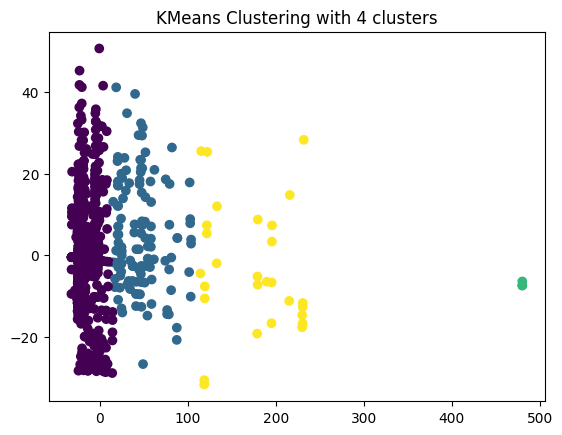

Silhouette Score for KMeans algorithm with 5 clusters: 0.615

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  1.412698  34.500000  1.174603  0.555556   65.597224   0.666667    0.476190   
1  2.564607  28.286868  0.397472  0.313202   14.769603   0.108146    0.308989   
2  1.000000  30.058824  0.882353  1.176471  238.187253   0.882353    0.647059   
3  1.000000  35.333333  0.000000  0.333333  512.329200   0.666667    0.333333   
4  1.000000  32.027879  0.606061  0.787879  131.108200   0.787879    0.666667   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.523810    0.309524    0.015873    0.674603  
1  0.691011    0.140449    0.105337    0.754213  
2  0.352941    0.529412    0.000000    0.470588  
3  0.666667    1.000000    0.000000    0.000000  
4  0.333333    0.515152    0.000000    0.484848  


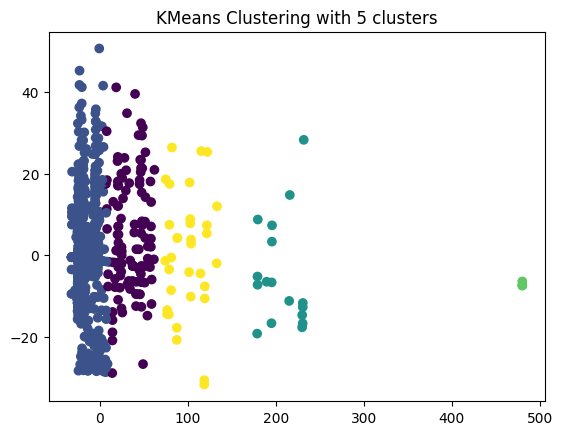

Silhouette Score for KMeans algorithm with 6 clusters: 0.449

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  2.092025  45.785276  0.226994  0.411043   19.999770   0.239264    0.276074   
1  1.000000  30.058824  0.882353  1.176471  238.187253   0.882353    0.647059   
2  1.408333  33.700000  1.216667  0.533333   66.823612   0.675000    0.483333   
3  1.000000  35.333333  0.000000  0.333333  512.329200   0.666667    0.333333   
4  2.691892  23.387838  0.446847  0.291892   13.517859   0.073874    0.318919   
5  1.000000  32.027879  0.606061  0.787879  131.108200   0.787879    0.666667   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.723926    0.128834    0.036810    0.834356  
1  0.352941    0.529412    0.000000    0.470588  
2  0.516667    0.300000    0.016667    0.683333  
3  0.666667    1.000000    0.000000    0.000000  
4  0.681081    0.147748    0.124324    0.727928  
5  0.333333    0.515152    0.000000    0.48484

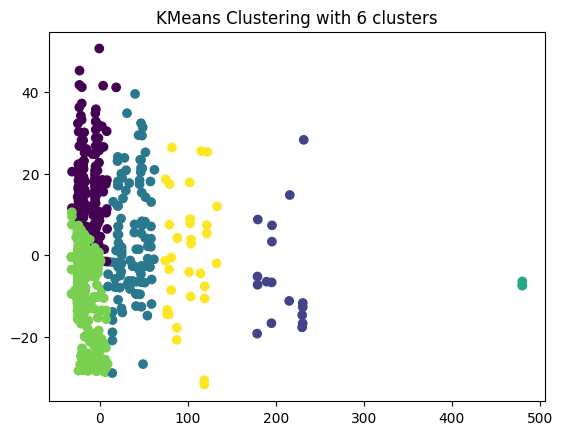

Silhouette Score for KMeans algorithm with 7 clusters: 0.479

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  2.048951  47.055944  0.237762  0.461538   20.813433   0.244755    0.293706   
1  1.000000  30.058824  0.882353  1.176471  238.187253   0.882353    0.647059   
2  1.333333  35.099099  1.072072  0.432432   68.552028   0.720721    0.495495   
3  1.000000  32.027879  0.606061  0.787879  131.108200   0.787879    0.666667   
4  1.000000  35.333333  0.000000  0.333333  512.329200   0.666667    0.333333   
5  2.305556  15.887153  1.375000  0.916667   27.705787   0.166667    0.451389   
6  2.797727  26.305682  0.181818  0.106818    9.559042   0.050000    0.268182   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.706294    0.104895    0.034965    0.860140  
1  0.352941    0.529412    0.000000    0.470588  
2  0.504505    0.297297    0.018018    0.684685  
3  0.333333    0.515152    0.000000    0.484848  
4  0.666667    

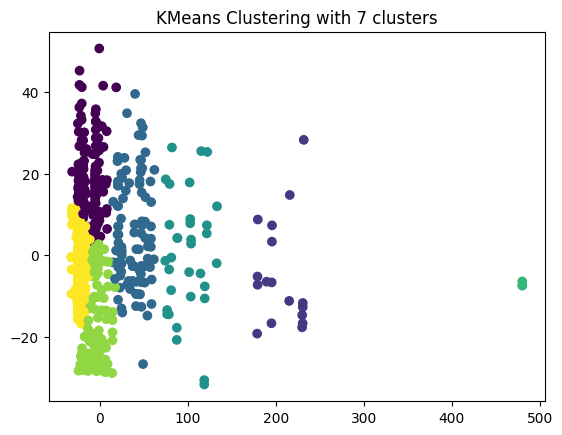

Silhouette Score for KMeans algorithm with 8 clusters: 0.493

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  2.091837  51.362245  0.132653  0.234694   18.130103   0.244898    0.255102   
1  1.000000  30.058824  0.882353  1.176471  238.187253   0.882353    0.647059   
2  2.701299   6.522727  1.935065  1.337662   26.802488   0.103896    0.467532   
3  1.324074  35.194444  1.092593  0.388889   69.127508   0.731481    0.490741   
4  2.794457  26.312933  0.163972  0.083141    9.274132   0.048499    0.267898   
5  1.000000  35.333333  0.000000  0.333333  512.329200   0.666667    0.333333   
6  1.000000  32.027879  0.606061  0.787879  131.108200   0.787879    0.666667   
7  1.950820  30.795082  0.655738  0.729508   28.354065   0.237705    0.409836   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.744898    0.091837    0.040816    0.867347  
1  0.352941    0.529412    0.000000    0.470588  
2  0.532468    0.142857    0.05194

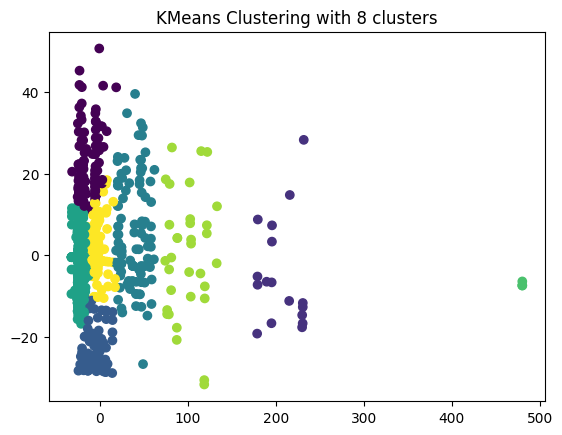

Silhouette Score for KMeans algorithm with 9 clusters: 0.479

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  2.702703   6.084459  1.932432  1.337838   26.671339   0.108108    0.459459   
1  1.000000  30.058824  0.882353  1.176471  238.187253   0.882353    0.647059   
2  2.797170  26.153302  0.158019  0.070755    9.175834   0.049528    0.264151   
3  1.301587  35.031746  1.460317  0.460317   78.874405   0.746032    0.571429   
4  1.000000  35.333333  0.000000  0.333333  512.329200   0.666667    0.333333   
5  1.000000  32.027879  0.606061  0.787879  131.108200   0.787879    0.666667   
6  1.413793  35.568966  0.603448  0.534483   52.879026   0.637931    0.413793   
7  2.115385  50.442308  0.144231  0.221154   17.595033   0.240385    0.259615   
8  2.034783  29.843478  0.686957  0.704348   26.530616   0.200000    0.408696   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.540541    0.148649    0.054054    0.797297  
1  

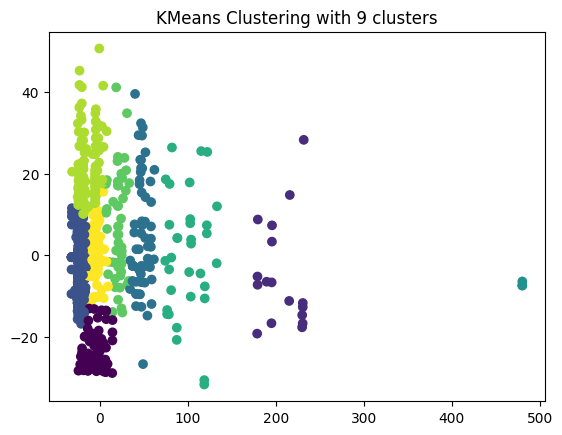

Silhouette Score for KMeans algorithm with 10 clusters: 0.487

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  2.807786  25.761557  0.158151  0.072993    9.259031   0.046229    0.267640   
1  1.000000  31.466250  0.593750  0.812500  131.879550   0.781250    0.687500   
2  1.000000  35.333333  0.000000  0.333333  512.329200   0.666667    0.333333   
3  1.410714  33.589286  0.714286  0.482143   54.299854   0.660714    0.392857   
4  1.000000  30.058824  0.882353  1.176471  238.187253   0.882353    0.647059   
5  1.395833  52.114583  0.270833  0.416667   29.773438   0.541667    0.312500   
6  1.306452  35.580645  1.467742  0.467742   79.714718   0.741935    0.564516   
7  2.044248  29.601770  0.690265  0.716814   26.447087   0.194690    0.415929   
8  2.698630   5.976027  1.890411  1.328767   26.394234   0.109589    0.465753   
9  2.578947  47.098684  0.092105  0.118421    9.929496   0.052632    0.223684   

   Sex_male  Embarked

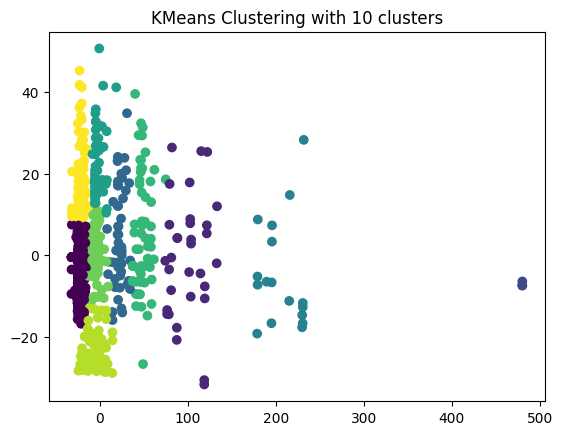

In [113]:
for n_clusters in range(2, 11):
    labels = cluster_data(train_data, algorithm='KMeans', n_clusters=n_clusters)
    plt.scatter(train_pca[:, 0], train_pca[:, 1], c=labels)
    plt.title(f"KMeans Clustering with {n_clusters} clusters")
    plt.show()

DBSCAN clustering

Silhouette Score for DBSCAN algorithm with 11 eps and 7 min samples: 0.599

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  34.445106  0.595745  0.914894  191.758687   0.808511   
 0  2.398082  29.097422  0.516787  0.347722   22.251638   0.189448   
 1  1.000000  27.500000  0.700000  0.700000  112.342490   0.800000   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.574468  0.425532    0.489362    0.000000    0.510638  
 0    0.335731  0.664269    0.164269    0.092326    0.743405  
 1    0.700000  0.300000    0.800000    0.000000    0.200000  


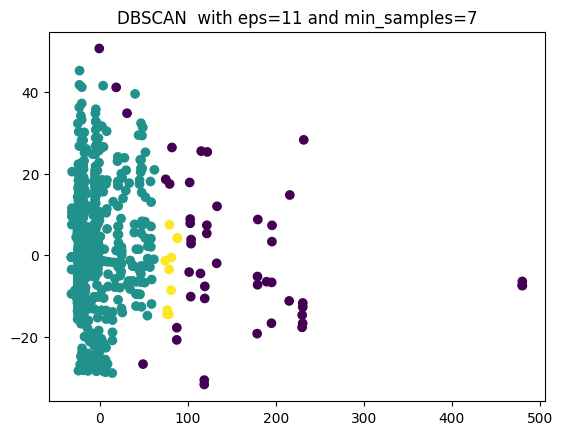

Silhouette Score for DBSCAN algorithm with 11 eps and 8 min samples: 0.777

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  33.550345  0.620690  0.879310  176.372124   0.810345    0.603448   
 0  2.39976  29.069928  0.516206  0.346939   22.166106   0.188475    0.334934   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.396552    0.534483    0.000000    0.465517  
 0  0.665066    0.164466    0.092437    0.743097  


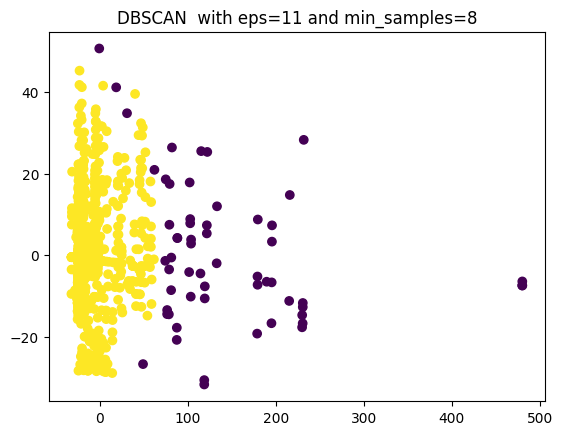

Silhouette Score for DBSCAN algorithm with 11 eps and 9 min samples: 0.774

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  34.168136  0.627119  0.881356  174.586156   0.813559   
 0  2.401442  29.020733  0.515625  0.346154   22.107411   0.187500   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.593220  0.406780    0.525424    0.000000    0.474576  
 0    0.335337  0.664663    0.164663    0.092548    0.742788  


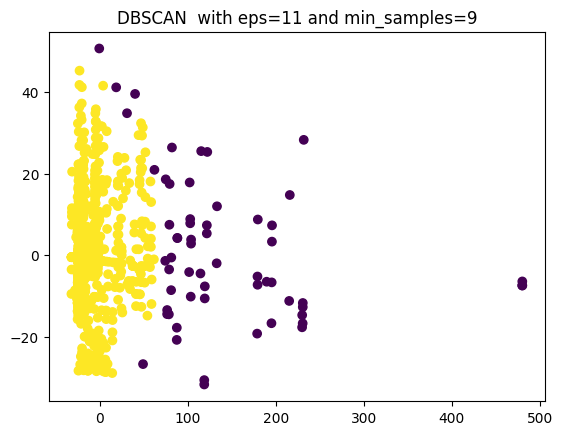

Silhouette Score for DBSCAN algorithm with 11 eps and 10 min samples: 0.774

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  34.168136  0.627119  0.881356  174.586156   0.813559   
 0  2.401442  29.020733  0.515625  0.346154   22.107411   0.187500   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.593220  0.406780    0.525424    0.000000    0.474576  
 0    0.335337  0.664663    0.164663    0.092548    0.742788  


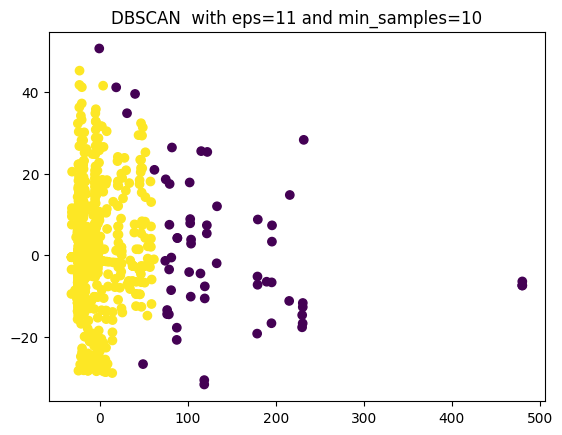

Silhouette Score for DBSCAN algorithm with 11 eps and 11 min samples: 0.774

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  34.168136  0.627119  0.881356  174.586156   0.813559   
 0  2.401442  29.020733  0.515625  0.346154   22.107411   0.187500   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.593220  0.406780    0.525424    0.000000    0.474576  
 0    0.335337  0.664663    0.164663    0.092548    0.742788  


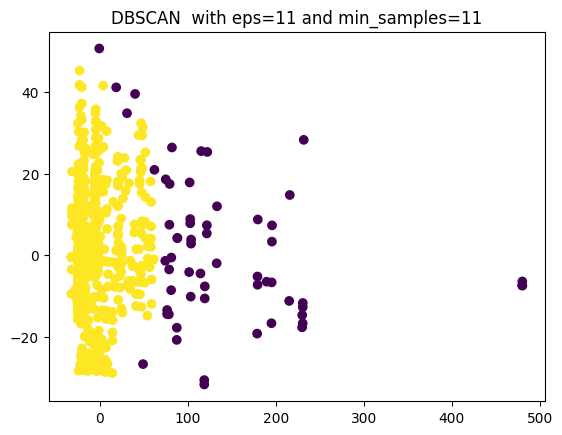

Silhouette Score for DBSCAN algorithm with 11 eps and 12 min samples: 0.774

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  34.168136  0.627119  0.881356  174.586156   0.813559   
 0  2.401442  29.020733  0.515625  0.346154   22.107411   0.187500   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.593220  0.406780    0.525424    0.000000    0.474576  
 0    0.335337  0.664663    0.164663    0.092548    0.742788  


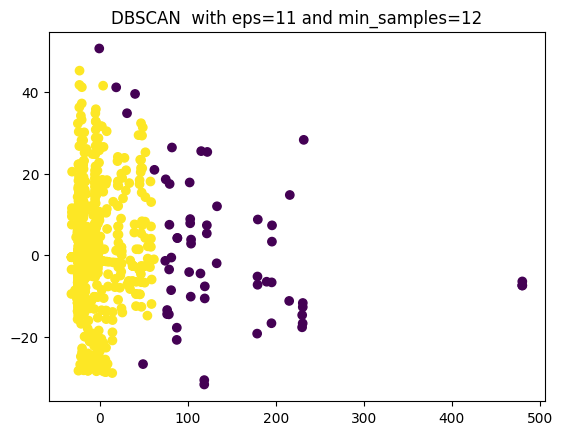

Silhouette Score for DBSCAN algorithm with 12 eps and 7 min samples: 0.610

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  34.045714  0.571429  0.880952  202.223114   0.785714   
 0  2.396407  29.140419  0.516168  0.348503   22.299216   0.190419   
 1  1.000000  28.500000  0.785714  0.857143  112.909514   0.857143   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.619048  0.380952    0.476190    0.000000    0.523810  
 0    0.335329  0.664671    0.165269    0.092216    0.742515  
 1    0.571429  0.428571    0.714286    0.000000    0.285714  


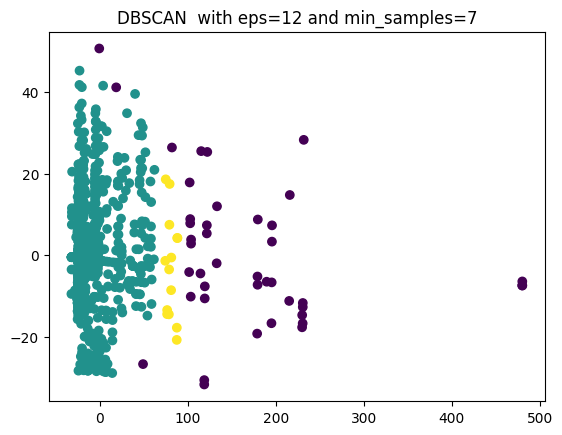

Silhouette Score for DBSCAN algorithm with 12 eps and 8 min samples: 0.606

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  33.509767  0.581395  0.906977  200.310949   0.790698   
 0  2.396407  29.140419  0.516168  0.348503   22.299216   0.190419   
 1  1.000000  29.846154  0.769231  0.769231  112.364092   0.846154   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.604651  0.395349    0.465116    0.000000    0.534884  
 0    0.335329  0.664671    0.165269    0.092216    0.742515  
 1    0.615385  0.384615    0.769231    0.000000    0.230769  


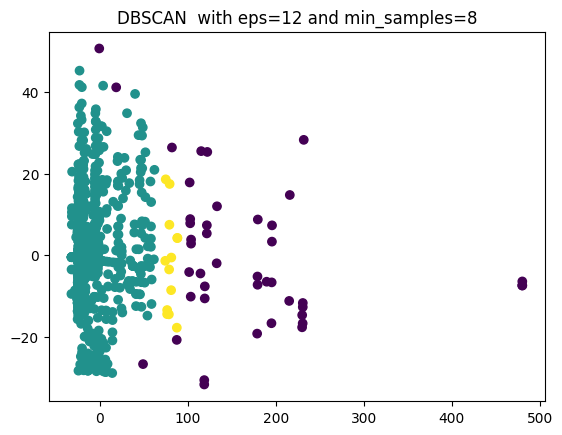

Silhouette Score for DBSCAN algorithm with 12 eps and 9 min samples: 0.782

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.659286  0.625000  0.875000  179.894714   0.803571   
 0  2.396407  29.140419  0.516168  0.348503   22.299216   0.190419   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.607143  0.392857    0.535714    0.000000    0.464286  
 0    0.335329  0.664671    0.165269    0.092216    0.742515  


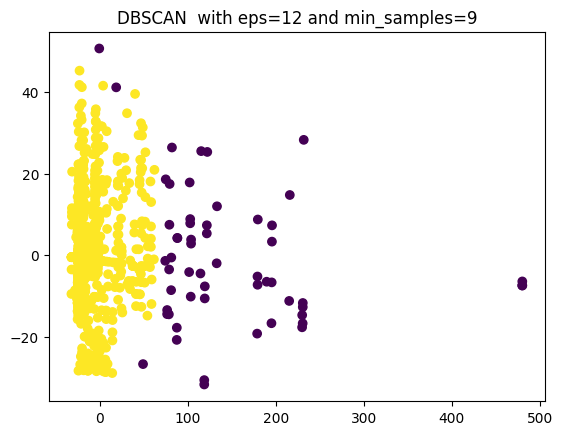

Silhouette Score for DBSCAN algorithm with 12 eps and 10 min samples: 0.782

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.659286  0.625000  0.875000  179.894714   0.803571   
 0  2.396407  29.140419  0.516168  0.348503   22.299216   0.190419   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.607143  0.392857    0.535714    0.000000    0.464286  
 0    0.335329  0.664671    0.165269    0.092216    0.742515  


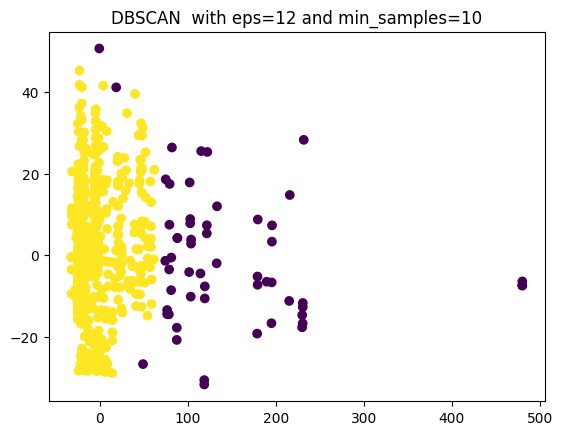

Silhouette Score for DBSCAN algorithm with 12 eps and 11 min samples: 0.782

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.659286  0.625000  0.875000  179.894714   0.803571   
 0  2.396407  29.140419  0.516168  0.348503   22.299216   0.190419   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.607143  0.392857    0.535714    0.000000    0.464286  
 0    0.335329  0.664671    0.165269    0.092216    0.742515  


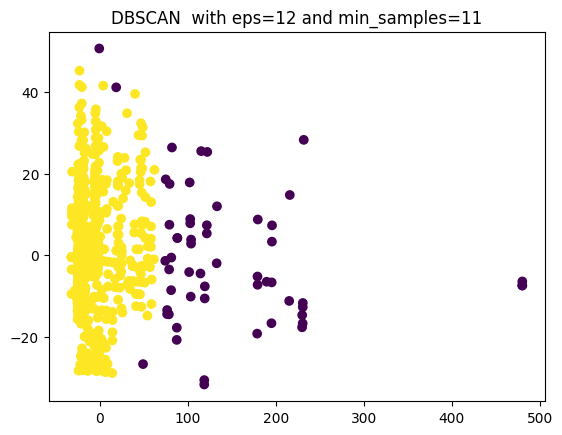

Silhouette Score for DBSCAN algorithm with 12 eps and 12 min samples: 0.782

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.659286  0.625000  0.875000  179.894714   0.803571   
 0  2.396407  29.140419  0.516168  0.348503   22.299216   0.190419   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.607143  0.392857    0.535714    0.000000    0.464286  
 0    0.335329  0.664671    0.165269    0.092216    0.742515  


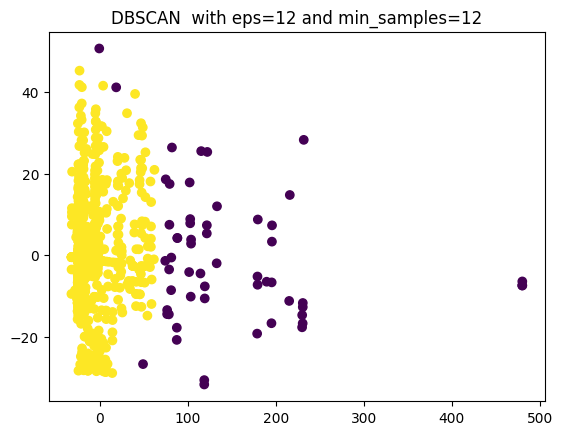

Silhouette Score for DBSCAN algorithm with 13 eps and 7 min samples: 0.612

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.924878  0.585366  0.902439  206.423678   0.780488   
 0  2.394737  29.201256  0.515550  0.348086   22.308427   0.191388   
 1  1.000000  28.500000  0.785714  0.857143  112.909514   0.857143   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.634146  0.365854    0.487805    0.000000    0.512195  
 0    0.334928  0.665072    0.165072    0.092105    0.742823  
 1    0.571429  0.428571    0.714286    0.000000    0.285714  


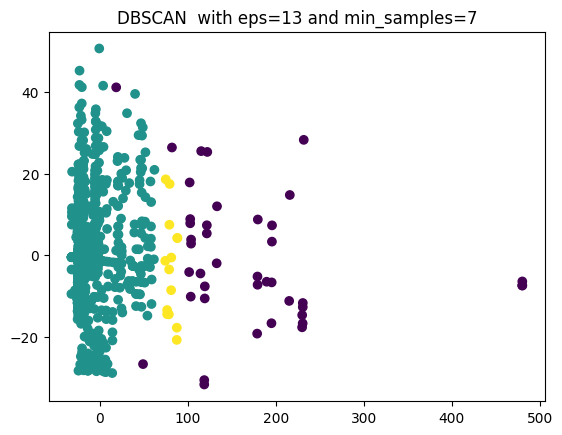

Silhouette Score for DBSCAN algorithm with 13 eps and 8 min samples: 0.608

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.402857  0.595238  0.928571  204.365971   0.785714   
 0  2.394737  29.201256  0.515550  0.348086   22.308427   0.191388   
 1  1.000000  29.846154  0.769231  0.769231  112.364092   0.846154   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.619048  0.380952    0.476190    0.000000    0.523810  
 0    0.334928  0.665072    0.165072    0.092105    0.742823  
 1    0.615385  0.384615    0.769231    0.000000    0.230769  


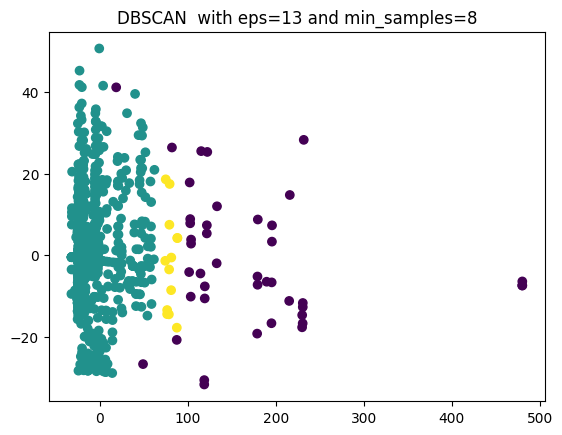

Silhouette Score for DBSCAN algorithm with 13 eps and 9 min samples: 0.601

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.753778  0.622222  0.933333  198.237313   0.800000   
 0  2.394737  29.201256  0.515550  0.348086   22.308427   0.191388   
 1  1.000000  27.500000  0.700000  0.700000  112.342490   0.800000   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.600000  0.400000    0.488889    0.000000    0.511111  
 0    0.334928  0.665072    0.165072    0.092105    0.742823  
 1    0.700000  0.300000    0.800000    0.000000    0.200000  


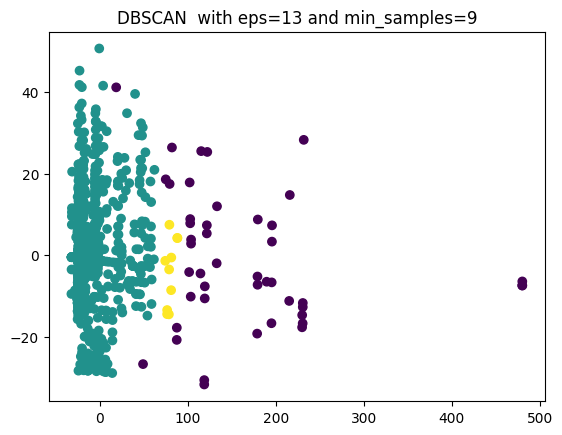

Silhouette Score for DBSCAN algorithm with 13 eps and 10 min samples: 0.599

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  33.780870  0.608696  0.913043  194.579980   0.804348   
 0  2.396407  29.140419  0.516168  0.348503   22.299216   0.190419   
 1  1.000000  27.500000  0.700000  0.700000  112.342490   0.800000   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.586957  0.413043    0.478261    0.000000    0.521739  
 0    0.335329  0.664671    0.165269    0.092216    0.742515  
 1    0.700000  0.300000    0.800000    0.000000    0.200000  


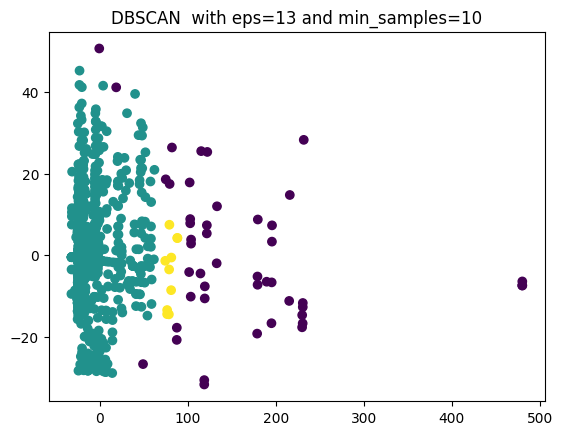

Silhouette Score for DBSCAN algorithm with 13 eps and 11 min samples: 0.782

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.659286  0.625000  0.875000  179.894714   0.803571   
 0  2.396407  29.140419  0.516168  0.348503   22.299216   0.190419   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.607143  0.392857    0.535714    0.000000    0.464286  
 0    0.335329  0.664671    0.165269    0.092216    0.742515  


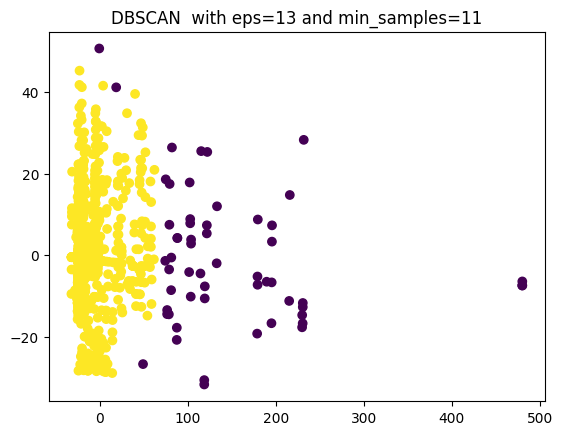

Silhouette Score for DBSCAN algorithm with 13 eps and 12 min samples: 0.782

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.659286  0.625000  0.875000  179.894714   0.803571   
 0  2.396407  29.140419  0.516168  0.348503   22.299216   0.190419   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.607143  0.392857    0.535714    0.000000    0.464286  
 0    0.335329  0.664671    0.165269    0.092216    0.742515  


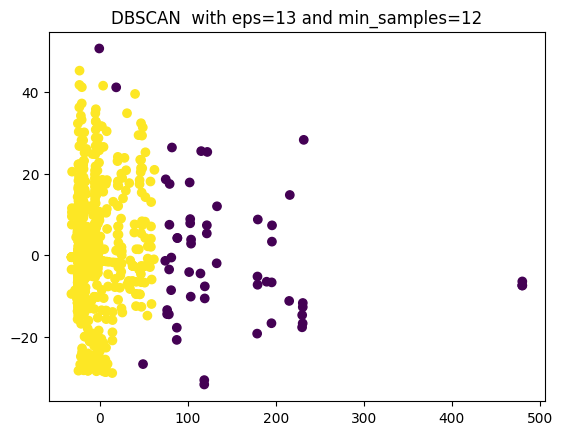

Silhouette Score for DBSCAN algorithm with 14 eps and 7 min samples: 0.680

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  34.169655  0.689655  1.068966  235.014372   0.793103   
 0  2.370153  29.160106  0.519389  0.358402   23.868903   0.203290   
 1  1.000000  32.272727  0.363636  0.363636  142.372336   0.727273   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.586207  0.413793    0.517241    0.000000    0.482759  
 0    0.338425  0.661575    0.173913    0.090482    0.735605  
 1    0.818182  0.181818    0.454545    0.000000    0.545455  


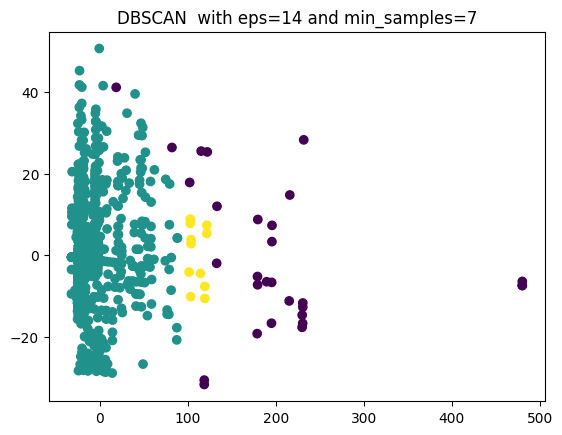

Silhouette Score for DBSCAN algorithm with 14 eps and 8 min samples: 0.680

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  34.578065  0.677419  1.032258  228.529574   0.806452   
 0  2.370153  29.160106  0.519389  0.358402   23.868903   0.203290   
 1  1.000000  30.444444  0.333333  0.333333  144.121744   0.666667   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.612903  0.387097    0.548387    0.000000    0.451613  
 0    0.338425  0.661575    0.173913    0.090482    0.735605  
 1    0.777778  0.222222    0.333333    0.000000    0.666667  


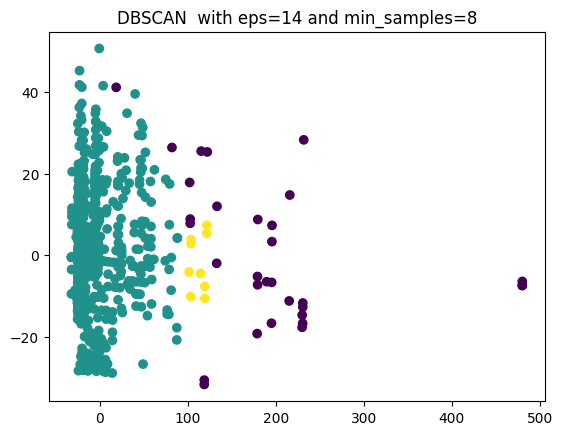

Silhouette Score for DBSCAN algorithm with 14 eps and 9 min samples: 0.681

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  35.482424  0.696970  1.000000  221.264397   0.818182    0.575758   
 0  2.37338  29.112191  0.518257  0.358068   23.669174   0.201413    0.339223   
 1  1.00000  30.444444  0.333333  0.333333  144.121744   0.666667    0.777778   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.424242    0.575758    0.000000    0.424242  
 0  0.660777    0.171967    0.090695    0.737338  
 1  0.222222    0.333333    0.000000    0.666667  


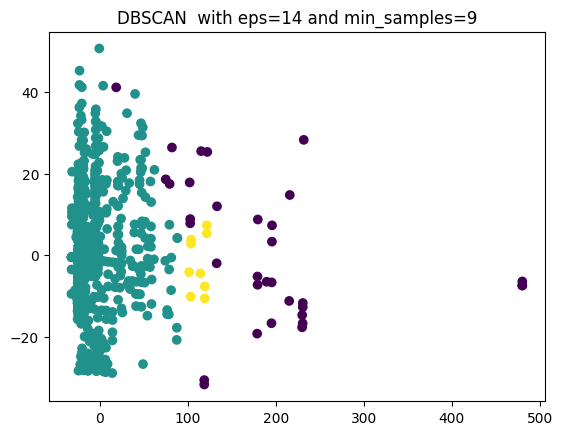

Silhouette Score for DBSCAN algorithm with 14 eps and 10 min samples: 0.601

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  33.407273  0.636364  0.909091  200.882291   0.795455   
 0  2.391408  29.172136  0.514320  0.349642   22.479867   0.192124   
 1  1.000000  27.222222  0.777778  0.777778  112.999989   0.888889   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.613636  0.386364    0.500000    0.000000    0.500000  
 0    0.335322  0.664678    0.165871    0.091885    0.742243  
 1    0.666667  0.333333    0.777778    0.000000    0.222222  


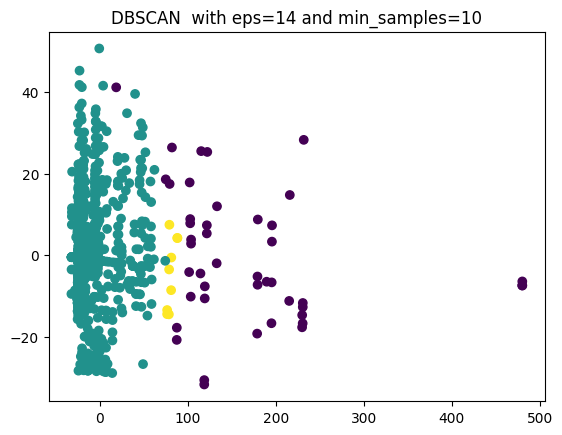

Silhouette Score for DBSCAN algorithm with 14 eps and 11 min samples: 0.789

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.356981  0.660377  0.886792  185.958881   0.811321   
 0  2.391408  29.172136  0.514320  0.349642   22.479867   0.192124   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.622642  0.377358    0.547170    0.000000    0.452830  
 0    0.335322  0.664678    0.165871    0.091885    0.742243  


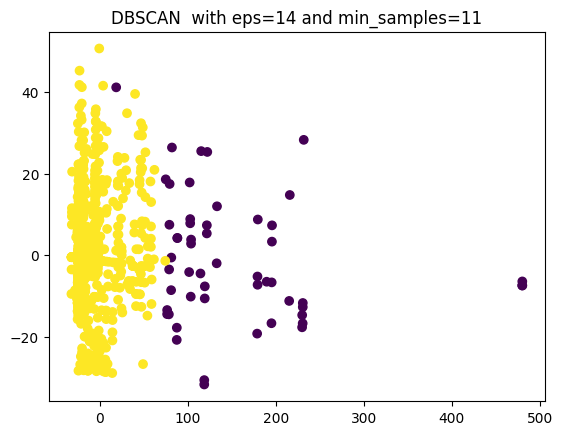

Silhouette Score for DBSCAN algorithm with 14 eps and 12 min samples: 0.785

Clusters grouping data
      Pclass        Age     SibSp    Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  33.239259  0.648148  0.87037  183.070754   0.814815    0.611111   
 0  2.39307  29.111410  0.514934  0.35006   22.470882   0.191159    0.335723   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.388889    0.537037    0.000000    0.462963  
 0  0.664277    0.166069    0.091995    0.741935  


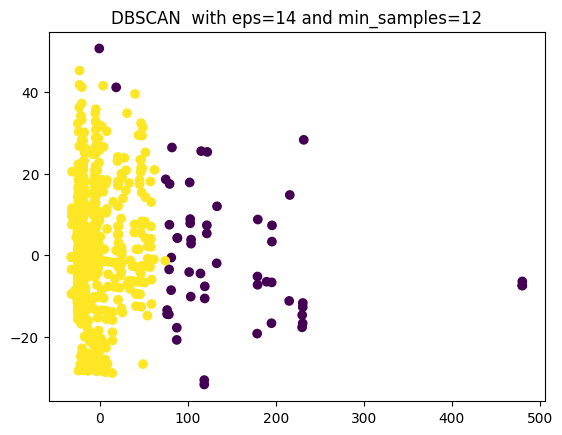

Silhouette Score for DBSCAN algorithm with 15 eps and 7 min samples: 0.683

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.219259  0.666667  1.148148  245.639356   0.851852   
 0  2.368545  29.209214  0.518779  0.357981   23.898992   0.203052   
 1  1.000000  33.750000  0.500000  0.333333  141.645475   0.666667   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.629630  0.370370    0.518519    0.000000    0.481481  
 0    0.338028  0.661972    0.174883    0.090376    0.734742  
 1    0.750000  0.250000    0.416667    0.000000    0.583333  


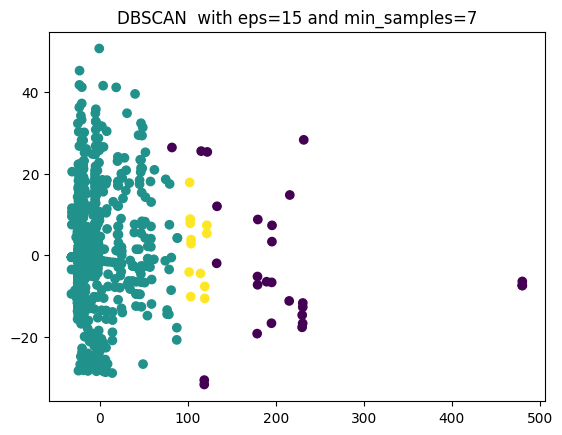

Silhouette Score for DBSCAN algorithm with 15 eps and 8 min samples: 0.683

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.219259  0.666667  1.148148  245.639356   0.851852   
 0  2.368545  29.209214  0.518779  0.357981   23.898992   0.203052   
 1  1.000000  33.750000  0.500000  0.333333  141.645475   0.666667   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.629630  0.370370    0.518519    0.000000    0.481481  
 0    0.338028  0.661972    0.174883    0.090376    0.734742  
 1    0.750000  0.250000    0.416667    0.000000    0.583333  


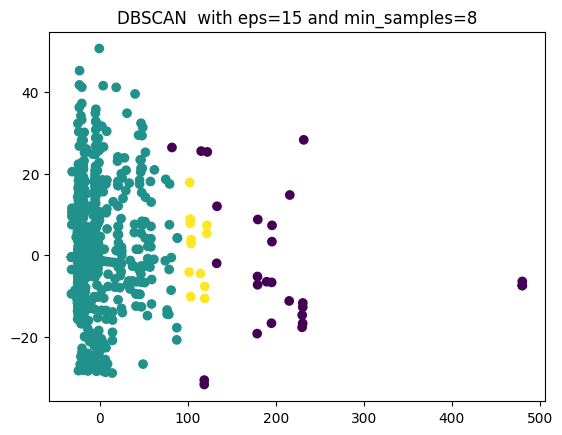

Silhouette Score for DBSCAN algorithm with 15 eps and 9 min samples: 0.682

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  34.372500  0.718750  1.031250  226.631903   0.843750   
 0  2.371765  29.161471  0.517647  0.357647   23.699568   0.201176   
 1  1.000000  30.444444  0.333333  0.333333  144.121744   0.666667   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.593750  0.406250    0.562500    0.000000    0.437500  
 0    0.338824  0.661176    0.172941    0.090588    0.736471  
 1    0.777778  0.222222    0.333333    0.000000    0.666667  


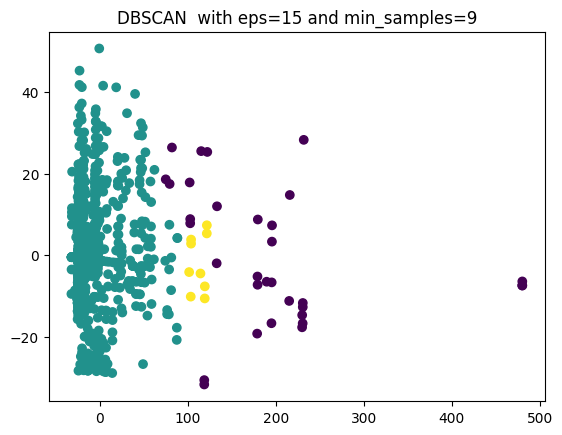

Silhouette Score for DBSCAN algorithm with 15 eps and 10 min samples: 0.612

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  33.510244  0.634146  0.878049  208.519917   0.804878    0.634146   
 0  2.38975  29.221990  0.513707  0.349225   22.512077   0.191895    0.334923   
 1  1.00000  24.545455  0.818182  1.000000  114.272718   0.909091    0.636364   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.365854    0.512195    0.000000    0.487805  
 0  0.665077    0.166865    0.091776    0.741359  
 1  0.363636    0.636364    0.000000    0.363636  


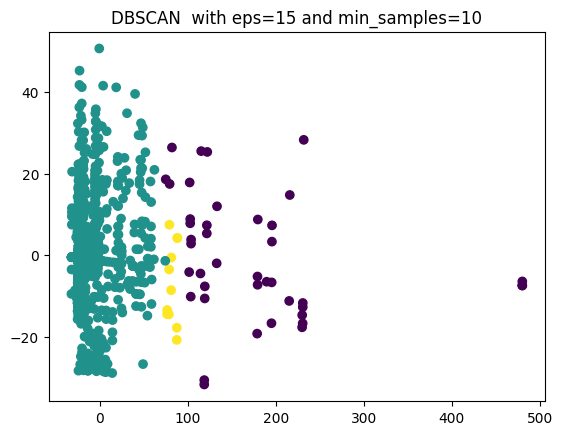

Silhouette Score for DBSCAN algorithm with 15 eps and 11 min samples: 0.612

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  33.640952  0.642857  0.880952  206.195236   0.809524    0.642857   
 0  2.38975  29.221990  0.513707  0.349225   22.512077   0.191895    0.334923   
 1  1.00000  23.100000  0.800000  1.000000  114.611660   0.900000    0.600000   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.357143    0.523810    0.000000    0.476190  
 0  0.665077    0.166865    0.091776    0.741359  
 1  0.400000    0.600000    0.000000    0.400000  


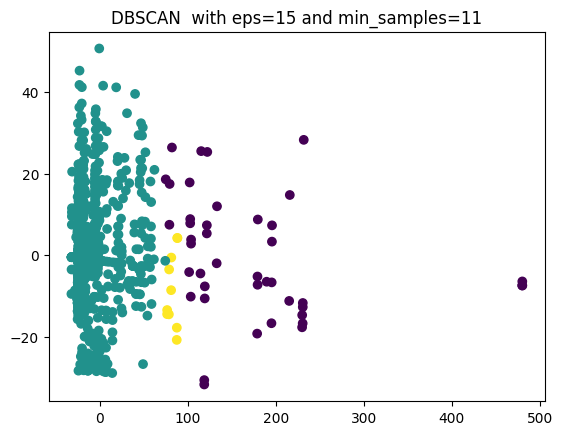

Silhouette Score for DBSCAN algorithm with 15 eps and 12 min samples: 0.792

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  31.613846  0.673077  0.903846  188.583010   0.826923    0.634615   
 0  2.38975  29.221990  0.513707  0.349225   22.512077   0.191895    0.334923   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.365385    0.538462    0.000000    0.461538  
 0  0.665077    0.166865    0.091776    0.741359  


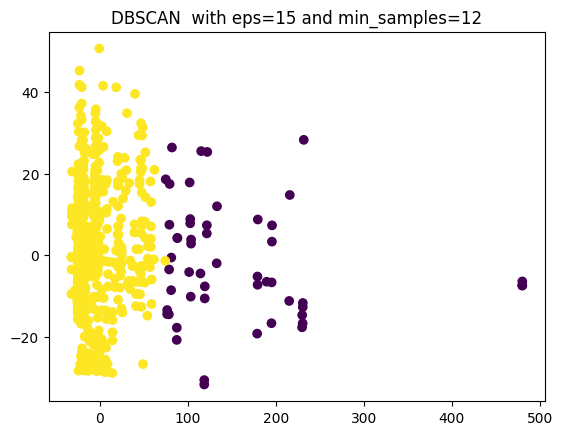

Silhouette Score for DBSCAN algorithm with 16 eps and 7 min samples: 0.786

Clusters grouping data
       Pclass       Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.000000  32.99600  0.850000  1.450000  253.877295   0.900000    0.650000   
 0  2.349537  29.27228  0.518519  0.357639   25.534360   0.209491    0.343750   
 1  1.000000  30.00000  0.142857  0.285714  222.102386   0.714286    0.571429   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.350000    0.450000     0.00000    0.550000  
 0  0.656250    0.178241     0.08912    0.732639  
 1  0.428571    0.714286     0.00000    0.285714  


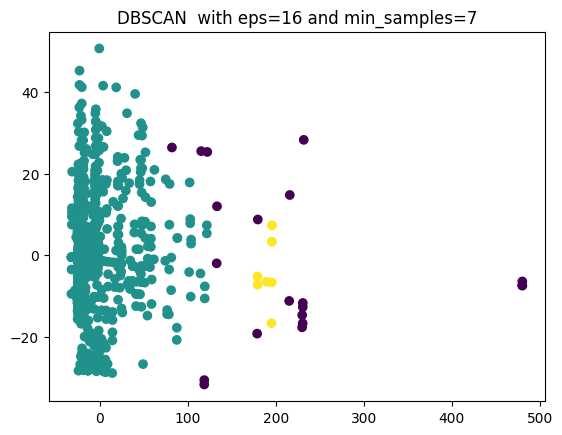

Silhouette Score for DBSCAN algorithm with 16 eps and 8 min samples: 0.827

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.219259  0.666667  1.148148  245.639356   0.851852   
 0  2.349537  29.272280  0.518519  0.357639   25.534360   0.209491   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1     0.62963   0.37037    0.518519     0.00000    0.481481  
 0     0.34375   0.65625    0.178241     0.08912    0.732639  


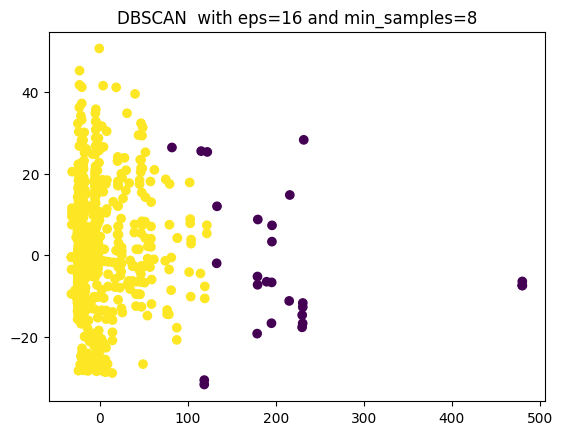

Silhouette Score for DBSCAN algorithm with 16 eps and 9 min samples: 0.827

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.219259  0.666667  1.148148  245.639356   0.851852   
 0  2.349537  29.272280  0.518519  0.357639   25.534360   0.209491   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1     0.62963   0.37037    0.518519     0.00000    0.481481  
 0     0.34375   0.65625    0.178241     0.08912    0.732639  


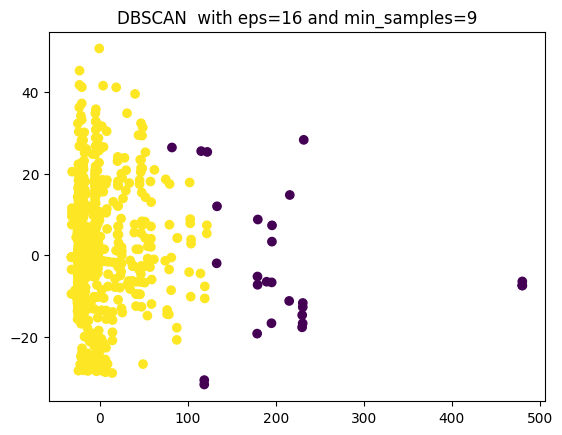

Silhouette Score for DBSCAN algorithm with 16 eps and 10 min samples: 0.821

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.094194  0.612903  1.096774  233.622181   0.838710   
 0  2.355814  29.263081  0.519767  0.355814   24.943793   0.206977   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.645161  0.354839    0.451613    0.000000    0.548387  
 0    0.341860  0.658140    0.179070    0.089535    0.731395  


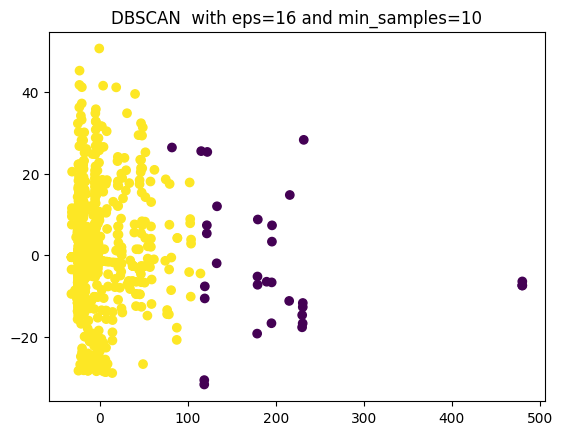

Silhouette Score for DBSCAN algorithm with 16 eps and 11 min samples: 0.817

Clusters grouping data
      Pclass        Age     SibSp    Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  32.203529  0.647059  1.00000  225.237991   0.794118    0.617647   
 0  2.36056  29.248833  0.518086  0.35706   24.545925   0.206534    0.341890   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.382353    0.470588    0.000000    0.529412  
 0  0.658110    0.177363    0.089848    0.732789  


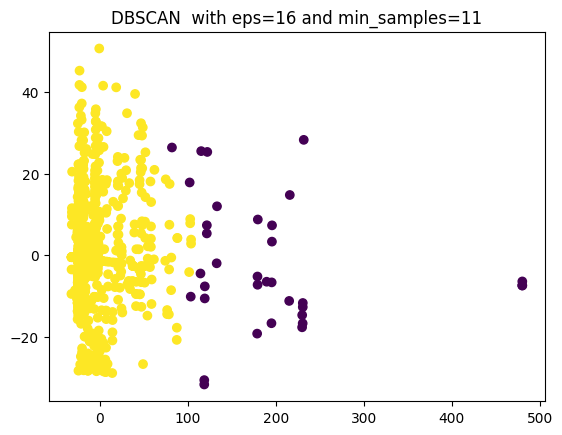

Silhouette Score for DBSCAN algorithm with 16 eps and 12 min samples: 0.636

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  30.049231  0.666667  1.025641  210.942949   0.820513   
 0  2.388095  29.246726  0.514286  0.348810   22.611974   0.192857   
 1  1.000000  35.166667  0.666667  0.583333  122.759708   0.833333   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.589744  0.410256    0.487179    0.000000    0.512821  
 0    0.334524  0.665476    0.167857    0.091667    0.740476  
 1    0.833333  0.166667    0.666667    0.000000    0.333333  


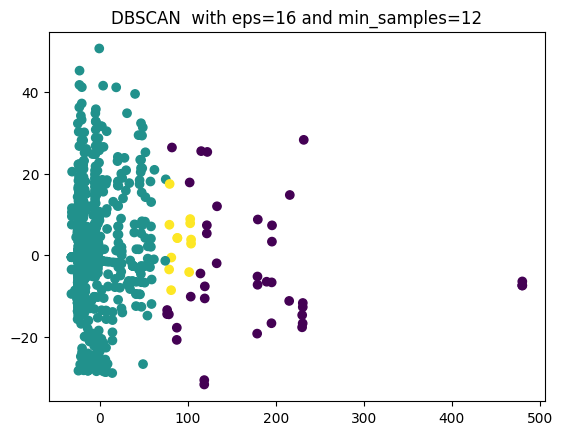

Silhouette Score for DBSCAN algorithm with 17 eps and 7 min samples: 0.784

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  33.465882  0.941176  1.470588  266.851471   0.941176    0.588235   
 0  2.34642  29.292436  0.518476  0.360277   25.856143   0.210162    0.345266   
 1  1.00000  28.125000  0.125000  0.375000  220.756775   0.750000    0.625000   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.411765    0.529412    0.000000    0.470588  
 0  0.654734    0.177829    0.088915    0.733256  
 1  0.375000    0.625000    0.000000    0.375000  


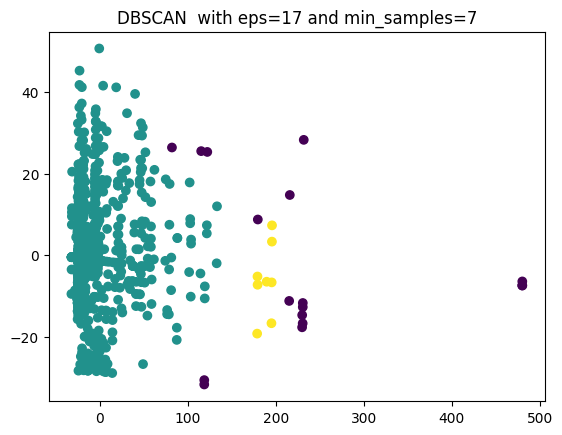

Silhouette Score for DBSCAN algorithm with 17 eps and 8 min samples: 0.786

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  33.943158  0.894737  1.473684  256.116232   0.894737   
 0  2.349537  29.272280  0.518519  0.357639   25.534360   0.209491   
 1  1.000000  28.125000  0.125000  0.375000  220.756775   0.750000   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.631579  0.368421    0.473684     0.00000    0.526316  
 0    0.343750  0.656250    0.178241     0.08912    0.732639  
 1    0.625000  0.375000    0.625000     0.00000    0.375000  


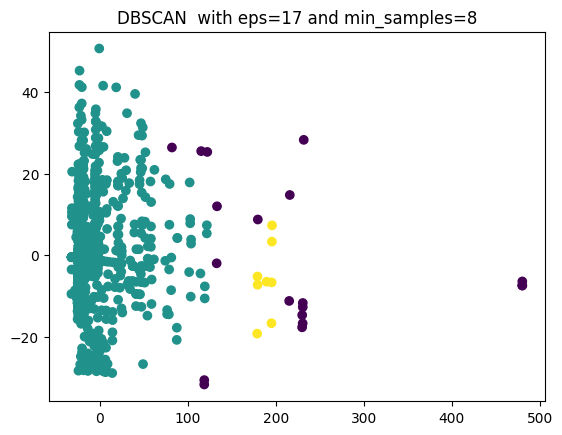

Silhouette Score for DBSCAN algorithm with 17 eps and 9 min samples: 0.827

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.219259  0.666667  1.148148  245.639356   0.851852   
 0  2.349537  29.272280  0.518519  0.357639   25.534360   0.209491   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1     0.62963   0.37037    0.518519     0.00000    0.481481  
 0     0.34375   0.65625    0.178241     0.08912    0.732639  


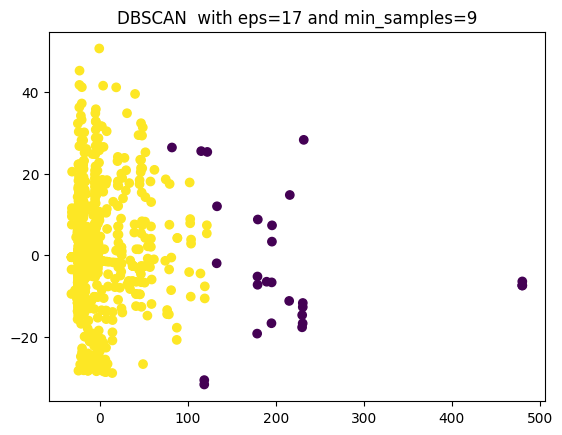

Silhouette Score for DBSCAN algorithm with 17 eps and 10 min samples: 0.821

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.094194  0.612903  1.096774  233.622181   0.838710   
 0  2.355814  29.263081  0.519767  0.355814   24.943793   0.206977   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.645161  0.354839    0.451613    0.000000    0.548387  
 0    0.341860  0.658140    0.179070    0.089535    0.731395  


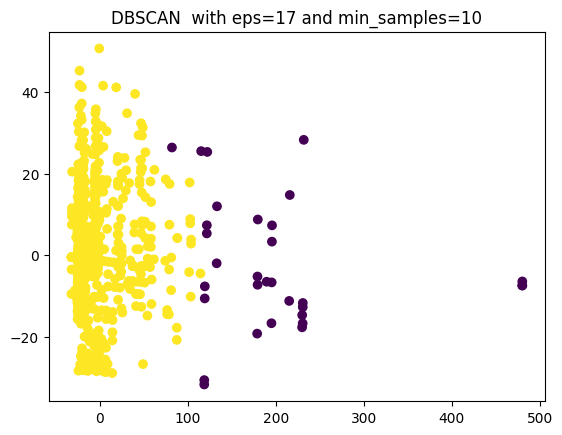

Silhouette Score for DBSCAN algorithm with 17 eps and 11 min samples: 0.817

Clusters grouping data
      Pclass        Age     SibSp    Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  32.203529  0.647059  1.00000  225.237991   0.794118    0.617647   
 0  2.36056  29.248833  0.518086  0.35706   24.545925   0.206534    0.341890   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.382353    0.470588    0.000000    0.529412  
 0  0.658110    0.177363    0.089848    0.732789  


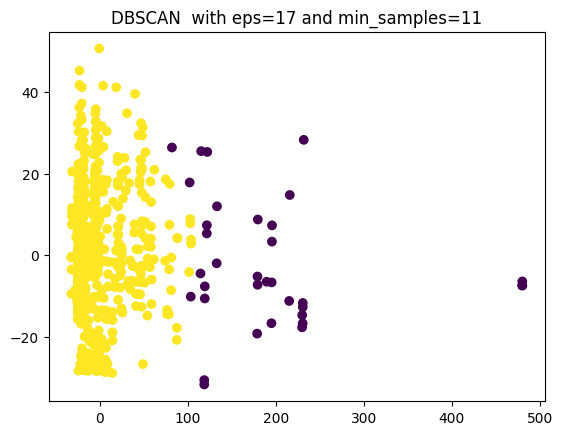

Silhouette Score for DBSCAN algorithm with 17 eps and 12 min samples: 0.817

Clusters grouping data
      Pclass        Age     SibSp    Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  32.203529  0.647059  1.00000  225.237991   0.794118    0.617647   
 0  2.36056  29.248833  0.518086  0.35706   24.545925   0.206534    0.341890   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.382353    0.470588    0.000000    0.529412  
 0  0.658110    0.177363    0.089848    0.732789  


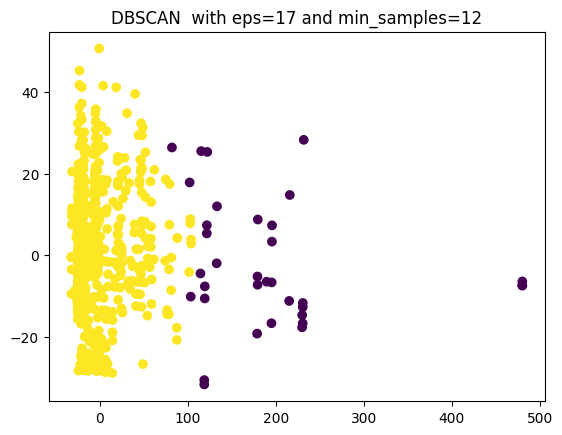

Silhouette Score for DBSCAN algorithm with 18 eps and 7 min samples: 0.785

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  31.932500  1.000000  1.437500  276.450000   0.937500   
 0  2.344867  29.325548  0.517878  0.362168   25.956972   0.211073   
 1  1.000000  28.125000  0.125000  0.375000  220.756775   0.750000   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.625000  0.375000    0.500000    0.000000    0.500000  
 0    0.344867  0.655133    0.178777    0.088812    0.732411  
 1    0.625000  0.375000    0.625000    0.000000    0.375000  


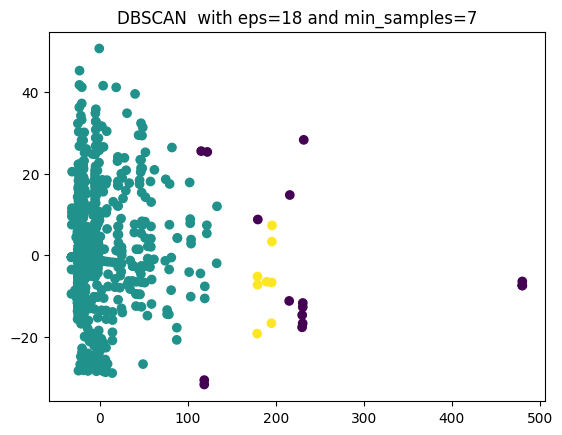

Silhouette Score for DBSCAN algorithm with 18 eps and 8 min samples: 0.786

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  33.943158  0.894737  1.473684  256.116232   0.894737   
 0  2.349537  29.272280  0.518519  0.357639   25.534360   0.209491   
 1  1.000000  28.125000  0.125000  0.375000  220.756775   0.750000   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.631579  0.368421    0.473684     0.00000    0.526316  
 0    0.343750  0.656250    0.178241     0.08912    0.732639  
 1    0.625000  0.375000    0.625000     0.00000    0.375000  


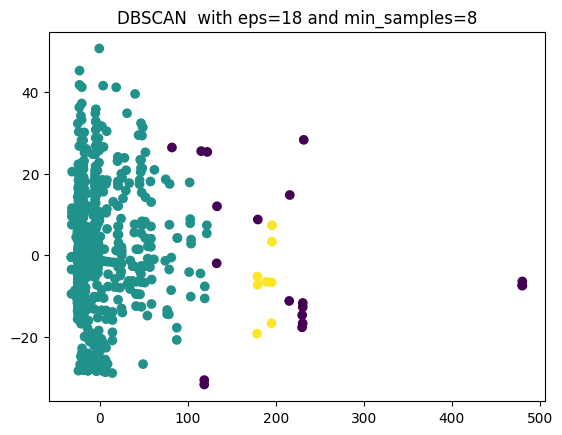

Silhouette Score for DBSCAN algorithm with 18 eps and 9 min samples: 0.827

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.219259  0.666667  1.148148  245.639356   0.851852   
 0  2.349537  29.272280  0.518519  0.357639   25.534360   0.209491   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1     0.62963   0.37037    0.518519     0.00000    0.481481  
 0     0.34375   0.65625    0.178241     0.08912    0.732639  


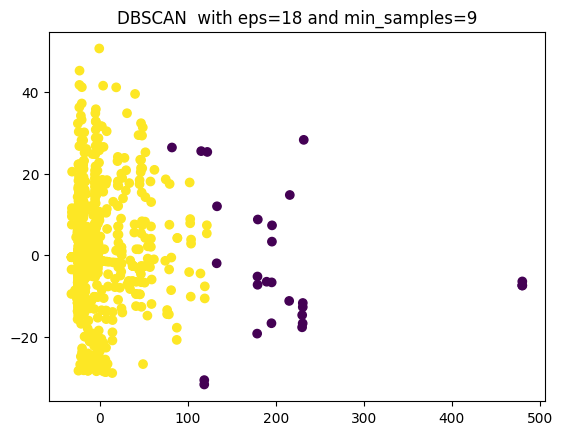

Silhouette Score for DBSCAN algorithm with 18 eps and 10 min samples: 0.827

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.219259  0.666667  1.148148  245.639356   0.851852   
 0  2.349537  29.272280  0.518519  0.357639   25.534360   0.209491   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1     0.62963   0.37037    0.518519     0.00000    0.481481  
 0     0.34375   0.65625    0.178241     0.08912    0.732639  


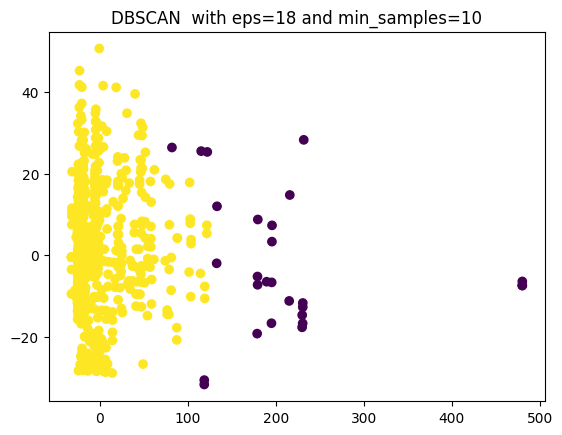

Silhouette Score for DBSCAN algorithm with 18 eps and 11 min samples: 0.684

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  32.854286  0.714286  1.107143  241.639736   0.821429    0.607143   
 0  2.36056  29.248833  0.518086  0.357060   24.545925   0.206534    0.341890   
 1  1.00000  29.166667  0.333333  0.500000  148.696517   0.666667    0.666667   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.392857    0.500000    0.000000    0.500000  
 0  0.658110    0.177363    0.089848    0.732789  
 1  0.333333    0.333333    0.000000    0.666667  


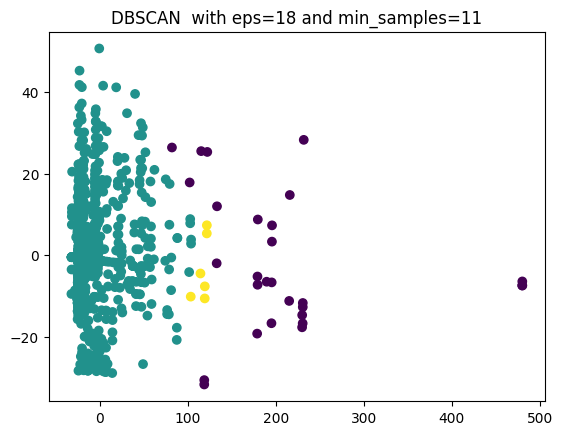

Silhouette Score for DBSCAN algorithm with 18 eps and 12 min samples: 0.817

Clusters grouping data
      Pclass        Age     SibSp    Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  32.203529  0.647059  1.00000  225.237991   0.794118    0.617647   
 0  2.36056  29.248833  0.518086  0.35706   24.545925   0.206534    0.341890   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.382353    0.470588    0.000000    0.529412  
 0  0.658110    0.177363    0.089848    0.732789  


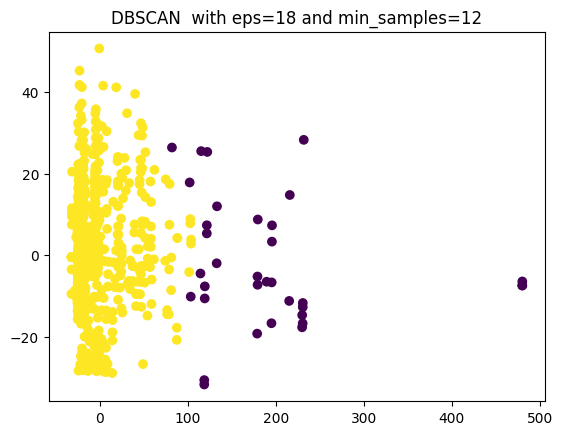

Silhouette Score for DBSCAN algorithm with 19 eps and 7 min samples: 0.785

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  29.280000  1.142857  1.500000  289.885714   0.928571   
 0  2.343318  29.358583  0.517281  0.362903   26.103868   0.211982   
 1  1.000000  29.777778  0.111111  0.444444  219.710189   0.777778   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.571429  0.428571    0.571429     0.00000    0.428571  
 0    0.345622  0.654378    0.178571     0.08871    0.732719  
 1    0.666667  0.333333    0.555556     0.00000    0.444444  


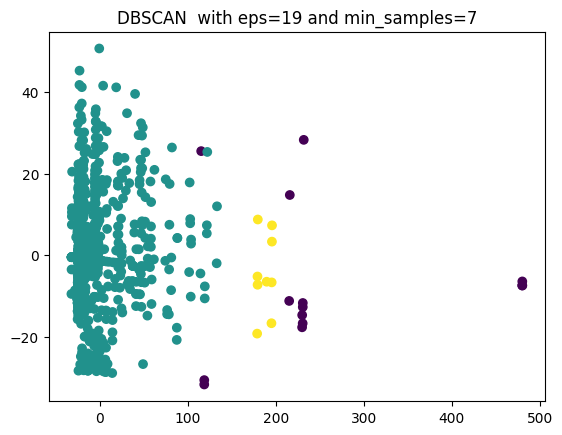

Silhouette Score for DBSCAN algorithm with 19 eps and 8 min samples: 0.785

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  29.280000  1.142857  1.500000  289.885714   0.928571   
 0  2.343318  29.358583  0.517281  0.362903   26.103868   0.211982   
 1  1.000000  29.777778  0.111111  0.444444  219.710189   0.777778   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.571429  0.428571    0.571429     0.00000    0.428571  
 0    0.345622  0.654378    0.178571     0.08871    0.732719  
 1    0.666667  0.333333    0.555556     0.00000    0.444444  


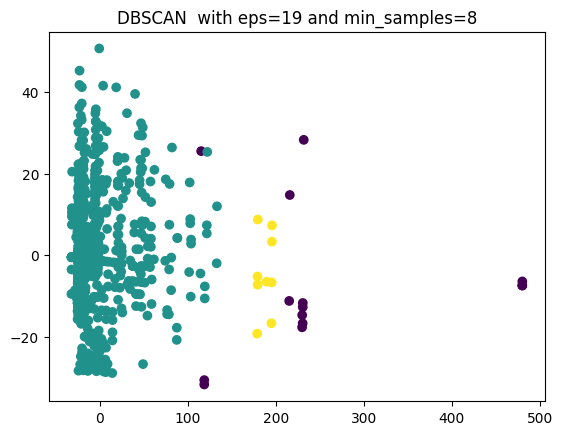

Silhouette Score for DBSCAN algorithm with 19 eps and 9 min samples: 0.785

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  31.194667  1.066667  1.533333  278.111667   0.933333   
 0  2.344867  29.325548  0.517878  0.361015   26.003325   0.211073   
 1  1.000000  29.777778  0.111111  0.444444  219.710189   0.777778   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.533333  0.466667    0.600000    0.000000    0.400000  
 0    0.346021  0.653979    0.177624    0.088812    0.733564  
 1    0.666667  0.333333    0.555556    0.000000    0.444444  


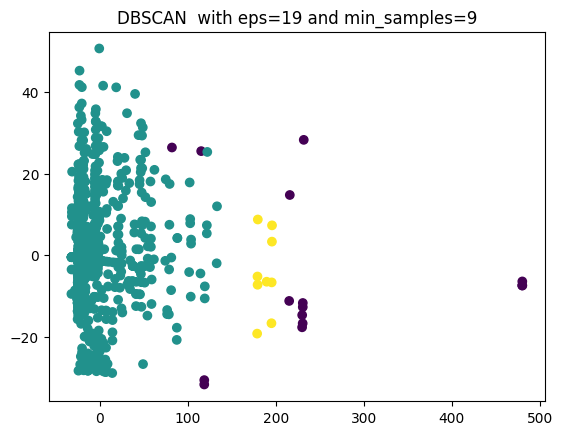

Silhouette Score for DBSCAN algorithm with 19 eps and 10 min samples: 0.832

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  30.663333  0.708333  1.125000  256.211113   0.875000   
 0  2.344867  29.325548  0.517878  0.361015   26.003325   0.211073   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.583333  0.416667    0.583333    0.000000    0.416667  
 0    0.346021  0.653979    0.177624    0.088812    0.733564  


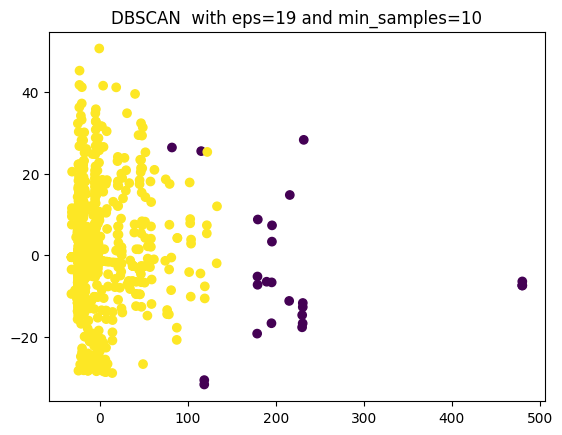

Silhouette Score for DBSCAN algorithm with 19 eps and 11 min samples: 0.828

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.266154  0.692308  1.115385  248.745996   0.846154   
 0  2.347977  29.274277  0.517919  0.359538   25.695437   0.210405   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.615385  0.384615    0.538462    0.000000    0.461538  
 0    0.344509  0.655491    0.178035    0.089017    0.732948  


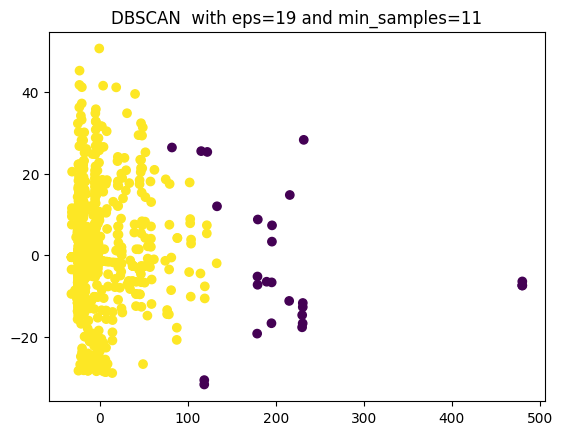

Silhouette Score for DBSCAN algorithm with 19 eps and 12 min samples: 0.828

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  32.266154  0.692308  1.115385  248.745996   0.846154   
 0  2.347977  29.274277  0.517919  0.359538   25.695437   0.210405   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.615385  0.384615    0.538462    0.000000    0.461538  
 0    0.344509  0.655491    0.178035    0.089017    0.732948  


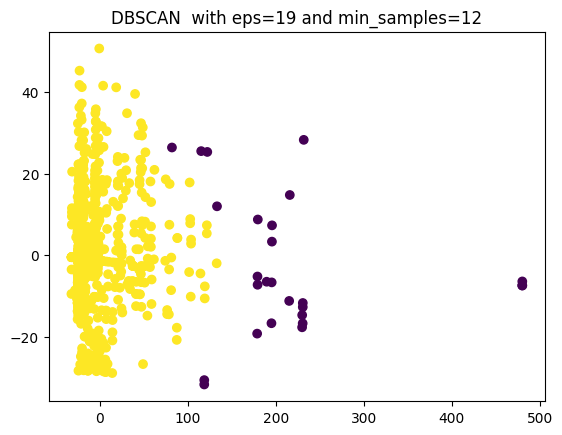

Silhouette Score for DBSCAN algorithm with 20 eps and 7 min samples: 0.785

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  27.070769  1.230769  1.615385  300.913785   0.923077   
 0  2.341772  29.391542  0.516686  0.362486   26.242438   0.212888   
 1  1.000000  29.777778  0.111111  0.444444  219.710189   0.777778   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.538462  0.461538    0.538462    0.000000    0.461538  
 0    0.346375  0.653625    0.179517    0.088608    0.731876  
 1    0.666667  0.333333    0.555556    0.000000    0.444444  


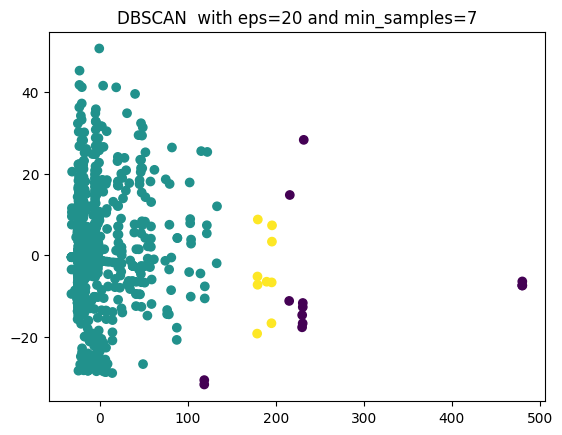

Silhouette Score for DBSCAN algorithm with 20 eps and 8 min samples: 0.785

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  27.070769  1.230769  1.615385  300.913785   0.923077   
 0  2.341772  29.391542  0.516686  0.362486   26.242438   0.212888   
 1  1.000000  29.777778  0.111111  0.444444  219.710189   0.777778   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.538462  0.461538    0.538462    0.000000    0.461538  
 0    0.346375  0.653625    0.179517    0.088608    0.731876  
 1    0.666667  0.333333    0.555556    0.000000    0.444444  


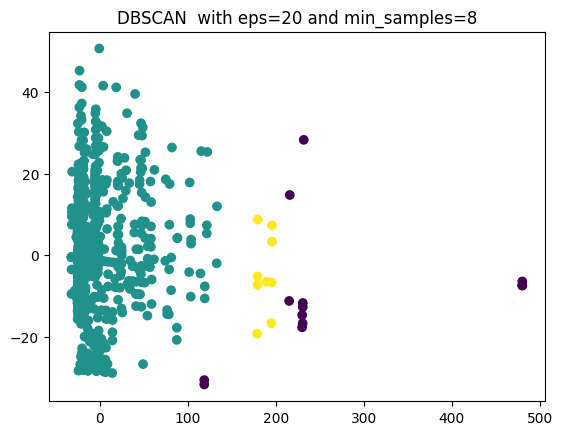

Silhouette Score for DBSCAN algorithm with 20 eps and 9 min samples: 0.785

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  27.070769  1.230769  1.615385  300.913785   0.923077   
 0  2.341772  29.391542  0.516686  0.362486   26.242438   0.212888   
 1  1.000000  29.777778  0.111111  0.444444  219.710189   0.777778   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.538462  0.461538    0.538462    0.000000    0.461538  
 0    0.346375  0.653625    0.179517    0.088608    0.731876  
 1    0.666667  0.333333    0.555556    0.000000    0.444444  


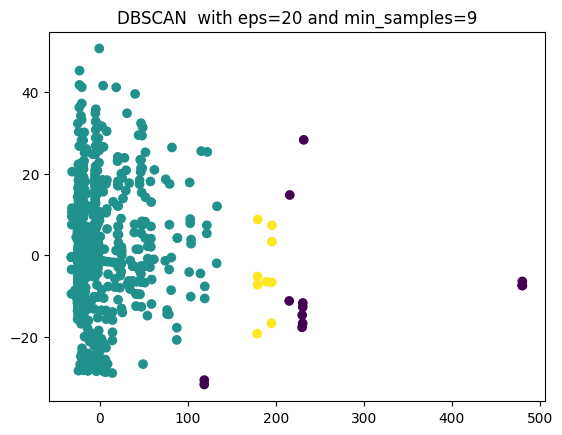

Silhouette Score for DBSCAN algorithm with 20 eps and 10 min samples: 0.840

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  28.178182  0.772727  1.136364  267.694132   0.863636   
 0  2.341772  29.391542  0.516686  0.362486   26.242438   0.212888   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.590909  0.409091    0.545455    0.000000    0.454545  
 0    0.346375  0.653625    0.179517    0.088608    0.731876  


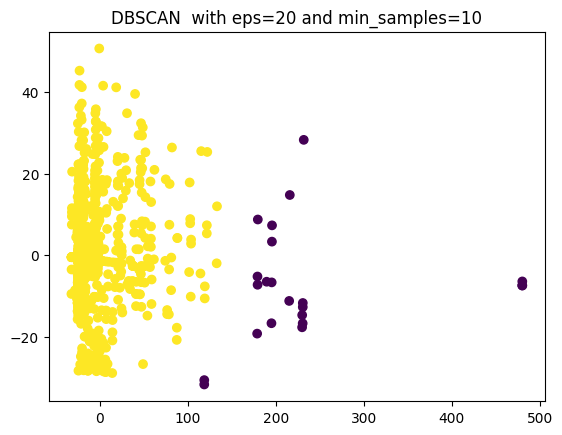

Silhouette Score for DBSCAN algorithm with 20 eps and 11 min samples: 0.840

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  28.178182  0.772727  1.136364  267.694132   0.863636   
 0  2.341772  29.391542  0.516686  0.362486   26.242438   0.212888   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.590909  0.409091    0.545455    0.000000    0.454545  
 0    0.346375  0.653625    0.179517    0.088608    0.731876  


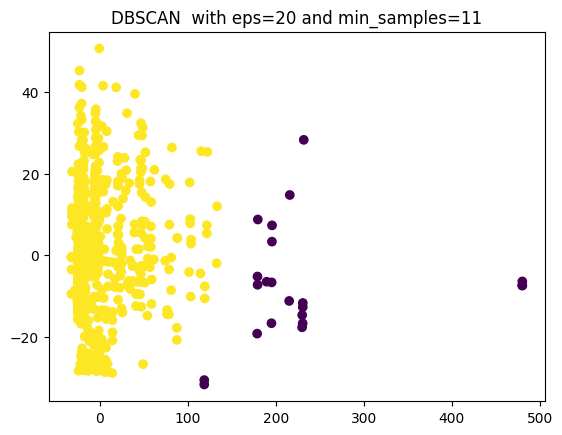

Silhouette Score for DBSCAN algorithm with 20 eps and 12 min samples: 0.835

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  29.474783  0.739130  1.173913  260.980257   0.869565   
 0  2.343318  29.358583  0.517281  0.360599   26.142170   0.211982   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.565217  0.434783    0.565217     0.00000    0.434783  
 0    0.346774  0.653226    0.178571     0.08871    0.732719  


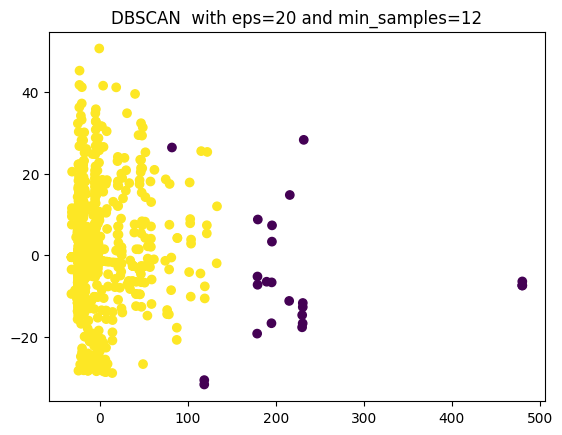

Silhouette Score for DBSCAN algorithm with 21 eps and 7 min samples: 0.811

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  36.820000  0.333333  1.333333  366.509733   0.833333    0.333333   
 0  2.34023  29.360057  0.517241  0.364368   26.386469   0.213793    0.347126   
 1  1.00000  26.466667  0.933333  1.000000  235.910833   0.866667    0.666667   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.666667    0.666667    0.000000    0.333333  
 0  0.652874    0.179310    0.088506    0.732184  
 1  0.333333    0.533333    0.000000    0.466667  


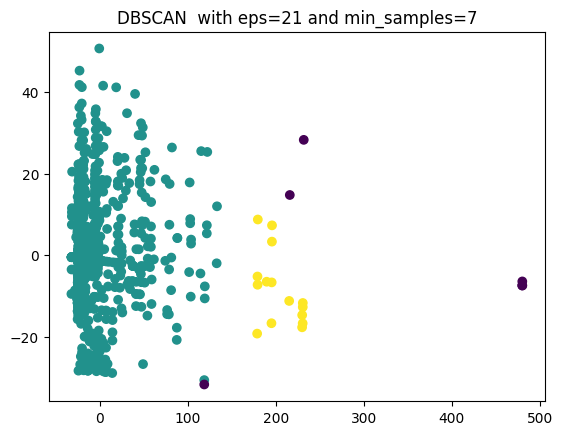

Silhouette Score for DBSCAN algorithm with 21 eps and 8 min samples: 0.811

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  36.820000  0.333333  1.333333  366.509733   0.833333    0.333333   
 0  2.34023  29.360057  0.517241  0.364368   26.386469   0.213793    0.347126   
 1  1.00000  26.466667  0.933333  1.000000  235.910833   0.866667    0.666667   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.666667    0.666667    0.000000    0.333333  
 0  0.652874    0.179310    0.088506    0.732184  
 1  0.333333    0.533333    0.000000    0.466667  


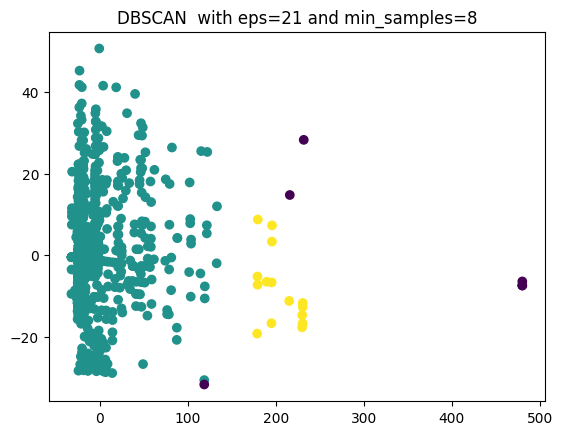

Silhouette Score for DBSCAN algorithm with 21 eps and 9 min samples: 0.789

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  29.629091  1.363636  1.636364  319.346218   0.909091    0.545455   
 0  2.34023  29.360057  0.517241  0.364368   26.386469   0.213793    0.347126   
 1  1.00000  29.200000  0.100000  0.500000  222.491250   0.800000    0.600000   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.454545    0.545455    0.000000    0.454545  
 0  0.652874    0.179310    0.088506    0.732184  
 1  0.400000    0.600000    0.000000    0.400000  


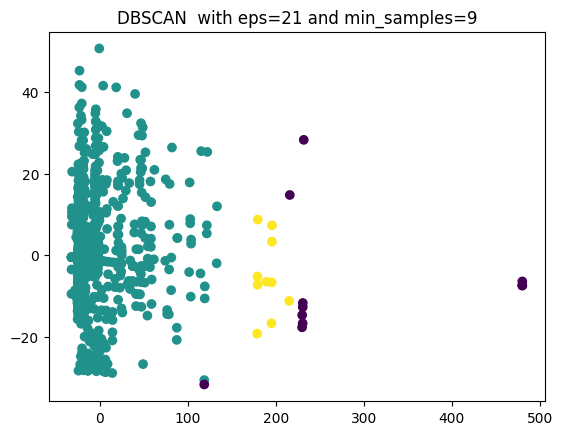

Silhouette Score for DBSCAN algorithm with 21 eps and 10 min samples: 0.843

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
-1  1.00000  29.424762  0.761905  1.095238  273.224805   0.857143    0.571429   
 0  2.34023  29.360057  0.517241  0.364368   26.386469   0.213793    0.347126   

    Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1  0.428571    0.571429    0.000000    0.428571  
 0  0.652874    0.179310    0.088506    0.732184  


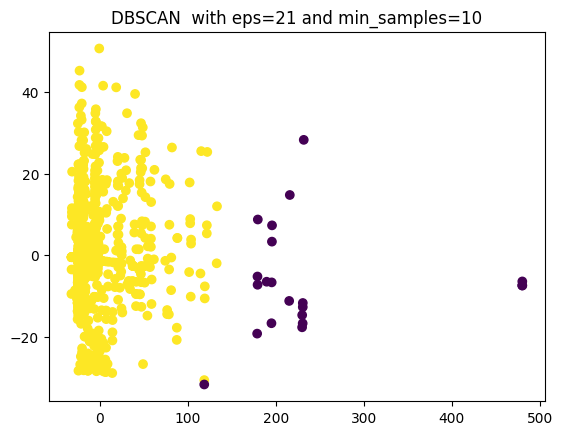

Silhouette Score for DBSCAN algorithm with 21 eps and 11 min samples: 0.840

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  28.178182  0.772727  1.136364  267.694132   0.863636   
 0  2.341772  29.391542  0.516686  0.362486   26.242438   0.212888   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.590909  0.409091    0.545455    0.000000    0.454545  
 0    0.346375  0.653625    0.179517    0.088608    0.731876  


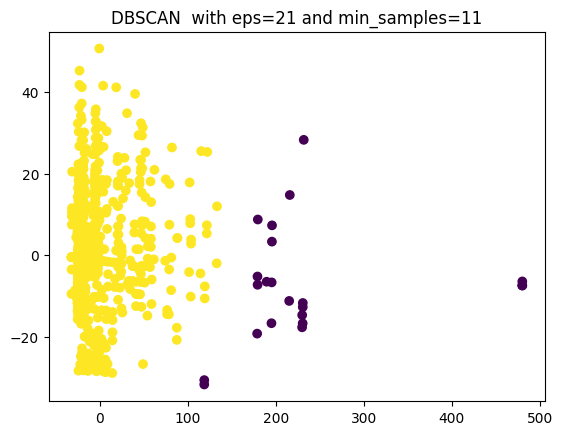

Silhouette Score for DBSCAN algorithm with 21 eps and 12 min samples: 0.840

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  28.178182  0.772727  1.136364  267.694132   0.863636   
 0  2.341772  29.391542  0.516686  0.362486   26.242438   0.212888   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.590909  0.409091    0.545455    0.000000    0.454545  
 0    0.346375  0.653625    0.179517    0.088608    0.731876  


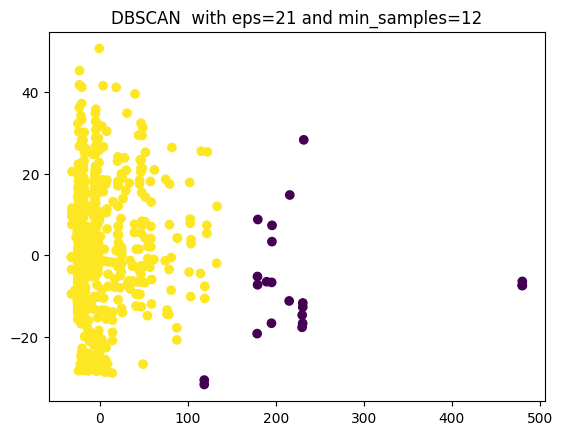

In [114]:
for eps in range(11, 22):
    for mis_s in range (7, 13):
        labels = cluster_data(train_data, algorithm='DBSCAN', eps=eps, min_s=mis_s)
        plt.scatter(train_pca[:, 0], train_pca[:, 1], c=labels)
        plt.title(f"DBSCAN  with eps={eps} and min_samples={mis_s}")
        plt.show()

After quick look through the plots, most likely the proper number of clusters for KMeans are 2-4; for DBSCAN eps = 16-19, min_s = 9-11.

Decision was made based on highest silhouette score values.

KMeans clustering

Silhouette Score for KMeans algorithm with 2 clusters: 0.827

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  2.359897  28.758355  0.429306  0.359897   22.444784   0.169666    0.347044   
1  1.000000  40.879310  0.689655  0.827586  211.723138   0.862069    0.586207   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.652956    0.213368    0.118252    0.668380  
1  0.413793    0.655172    0.000000    0.344828  


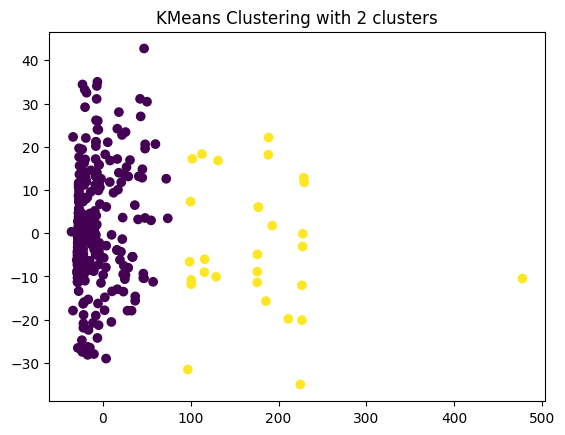

Silhouette Score for KMeans algorithm with 3 clusters: 0.673

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  2.523810  27.385417  0.354167  0.276786   15.135553   0.086310    0.324405   
1  1.000000  43.775000  0.750000  0.950000  243.882925   0.850000    0.650000   
2  1.274194  37.024194  0.854839  0.838710   79.157865   0.725806    0.483871   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.675595    0.175595    0.133929    0.690476  
1  0.350000    0.600000    0.000000    0.400000  
2  0.516129    0.500000    0.016129    0.483871  


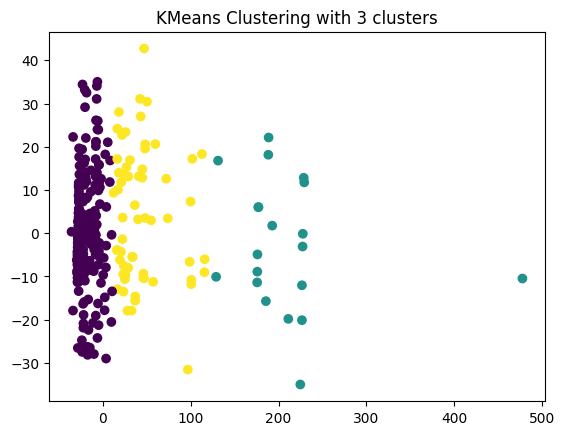

Silhouette Score for KMeans algorithm with 4 clusters: 0.662

Clusters grouping data
      Pclass        Age     SibSp     Parch        Fare  CabinBool  Sex_female  \
0  2.537538  27.349850  0.357357  0.279279   14.866504   0.087087    0.327327   
1  1.000000  42.613636  0.772727  0.909091  218.861368   0.818182    0.590909   
2  1.274194  36.604839  0.822581  0.806452   74.083335   0.693548    0.467742   
3  1.000000  58.000000  0.000000  1.000000  512.329200   1.000000    1.000000   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.672673    0.177177    0.135135    0.687688  
1  0.409091    0.545455    0.000000    0.454545  
2  0.532258    0.483871    0.016129    0.500000  
3  0.000000    1.000000    0.000000    0.000000  


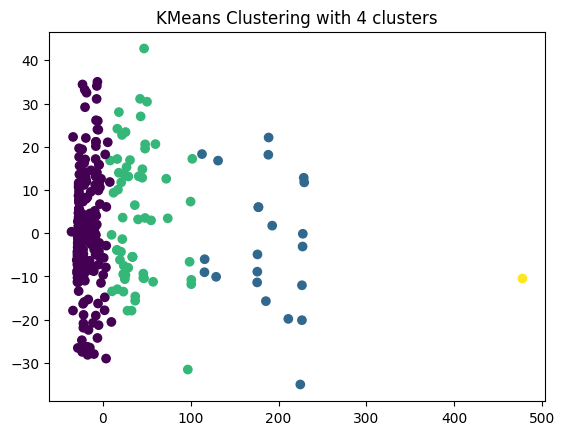

In [115]:
pca = PCA(n_components=2)
test_pca = pca.fit_transform(test_data)

for n_clusters in range(2, 5):
    labels = cluster_data(test_data, algorithm='KMeans', n_clusters=n_clusters)
    plt.scatter(test_pca[:, 0], test_pca[:, 1], c=labels)
    plt.title(f"KMeans Clustering with {n_clusters} clusters")
    plt.show()

DBSCAN clustering

Silhouette Score for DBSCAN algorithm with 16 eps and 9 min samples: 0.817

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  42.140625  0.687500  0.750000  201.067062   0.875000   
 0  2.370466  28.559585  0.427461  0.362694   21.857113   0.163212   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.625000  0.375000    0.656250    0.000000    0.343750  
 0    0.341969  0.658031    0.209845    0.119171    0.670984  


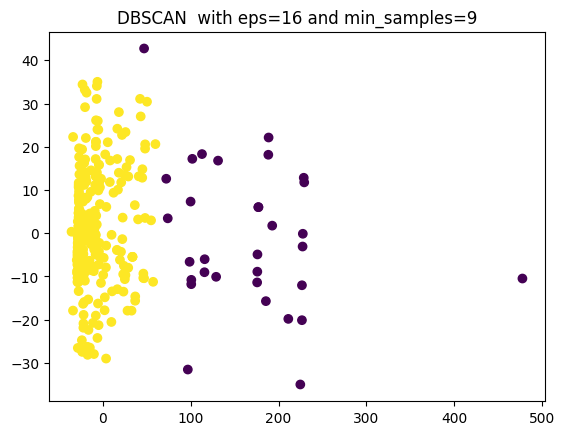

Silhouette Score for DBSCAN algorithm with 16 eps and 10 min samples: 0.804

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  43.757143  0.685714  0.771429  191.030123   0.885714   
 0  2.381201  28.305483  0.425587  0.357702   21.370594   0.156658   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.600000  0.400000    0.657143    0.000000    0.342857  
 0    0.342037  0.657963    0.206266    0.120104    0.673629  


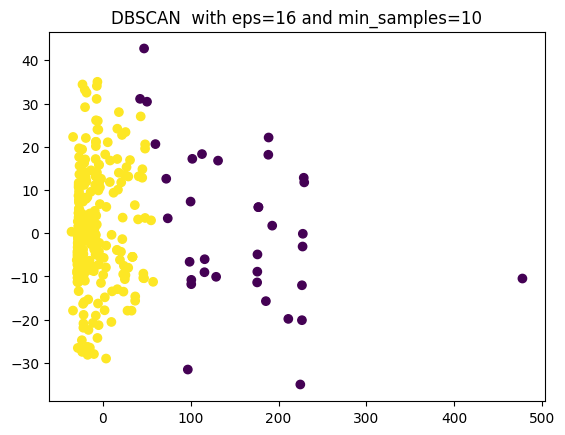

Silhouette Score for DBSCAN algorithm with 16 eps and 11 min samples: 0.801

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  43.180556  0.666667  0.750000  188.320953   0.888889   
 0  2.384817  28.319372  0.426702  0.358639   21.181774   0.154450   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.583333  0.416667    0.638889    0.000000    0.361111  
 0    0.342932  0.657068    0.206806    0.120419    0.672775  


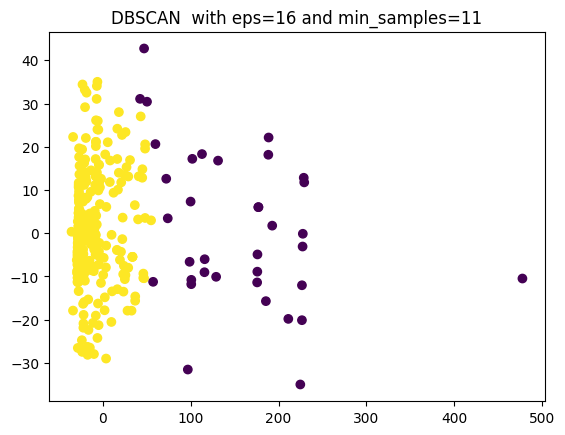

Silhouette Score for DBSCAN algorithm with 17 eps and 9 min samples: 0.821

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  41.048387  0.677419  0.774194  205.009548   0.870968   
 0  2.366925  28.682171  0.428941  0.361757   22.004382   0.165375   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.612903  0.387097    0.677419    0.000000    0.322581  
 0    0.343669  0.656331    0.209302    0.118863    0.671835  


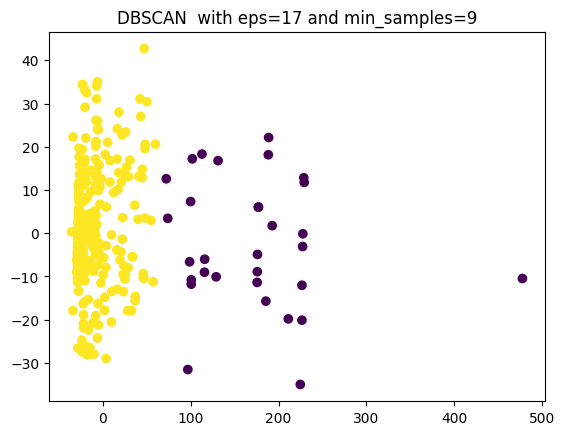

Silhouette Score for DBSCAN algorithm with 17 eps and 10 min samples: 0.821

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  41.048387  0.677419  0.774194  205.009548   0.870968   
 0  2.366925  28.682171  0.428941  0.361757   22.004382   0.165375   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.612903  0.387097    0.677419    0.000000    0.322581  
 0    0.343669  0.656331    0.209302    0.118863    0.671835  


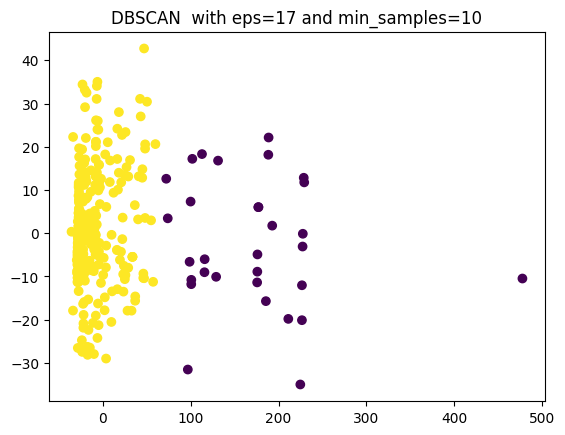

Silhouette Score for DBSCAN algorithm with 17 eps and 11 min samples: 0.817

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  42.140625  0.687500  0.750000  201.067062   0.875000   
 0  2.370466  28.559585  0.427461  0.362694   21.857113   0.163212   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.625000  0.375000    0.656250    0.000000    0.343750  
 0    0.341969  0.658031    0.209845    0.119171    0.670984  


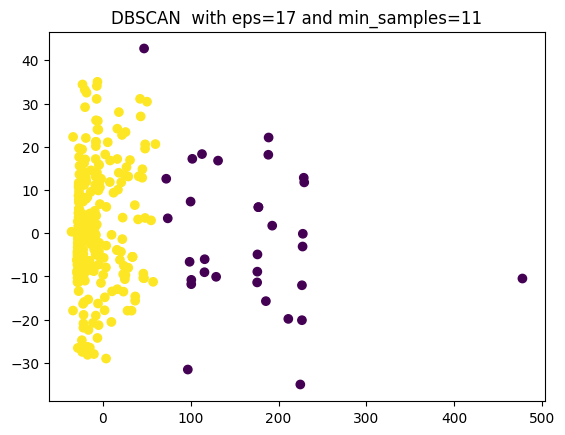

Silhouette Score for DBSCAN algorithm with 18 eps and 9 min samples: 0.821

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  41.048387  0.677419  0.774194  205.009548   0.870968   
 0  2.366925  28.682171  0.428941  0.361757   22.004382   0.165375   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.612903  0.387097    0.677419    0.000000    0.322581  
 0    0.343669  0.656331    0.209302    0.118863    0.671835  


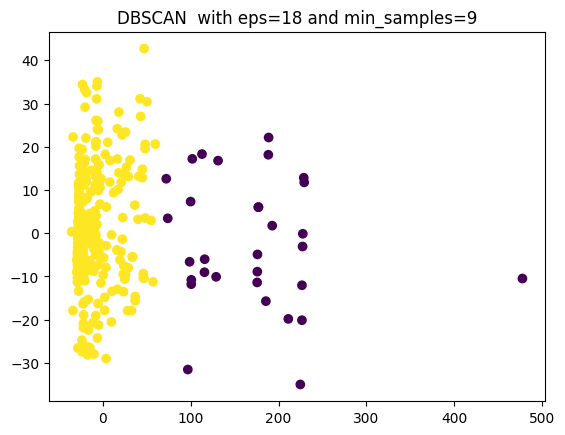

Silhouette Score for DBSCAN algorithm with 18 eps and 10 min samples: 0.821

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  41.048387  0.677419  0.774194  205.009548   0.870968   
 0  2.366925  28.682171  0.428941  0.361757   22.004382   0.165375   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.612903  0.387097    0.677419    0.000000    0.322581  
 0    0.343669  0.656331    0.209302    0.118863    0.671835  


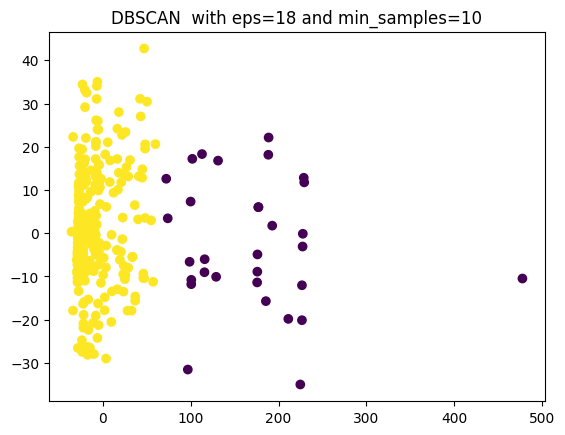

Silhouette Score for DBSCAN algorithm with 18 eps and 11 min samples: 0.821

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  41.048387  0.677419  0.774194  205.009548   0.870968   
 0  2.366925  28.682171  0.428941  0.361757   22.004382   0.165375   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.612903  0.387097    0.677419    0.000000    0.322581  
 0    0.343669  0.656331    0.209302    0.118863    0.671835  


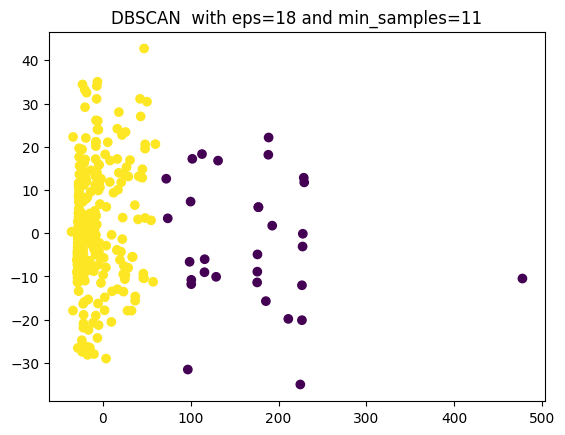

Silhouette Score for DBSCAN algorithm with 19 eps and 9 min samples: 0.824

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  40.816667  0.666667  0.800000  208.295700   0.866667   
 0  2.363402  28.731959  0.430412  0.360825   22.221961   0.167526   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.600000  0.400000    0.666667    0.000000    0.333333  
 0    0.345361  0.654639    0.211340    0.118557    0.670103  


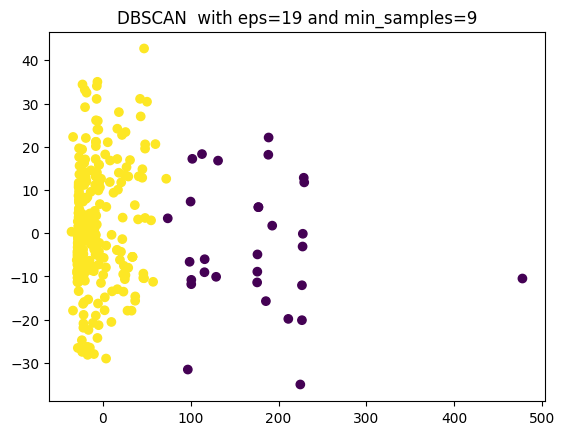

Silhouette Score for DBSCAN algorithm with 19 eps and 10 min samples: 0.821

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  41.048387  0.677419  0.774194  205.009548   0.870968   
 0  2.366925  28.682171  0.428941  0.361757   22.004382   0.165375   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.612903  0.387097    0.677419    0.000000    0.322581  
 0    0.343669  0.656331    0.209302    0.118863    0.671835  


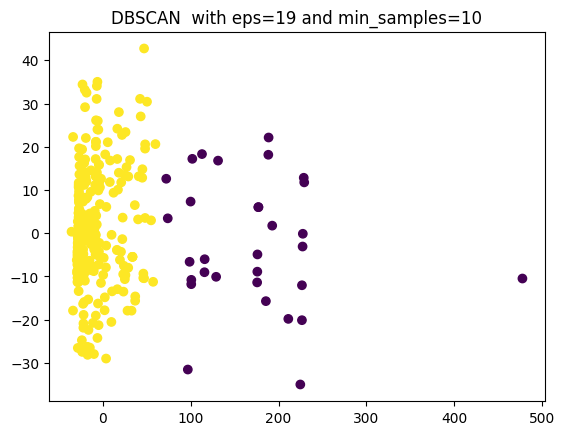

Silhouette Score for DBSCAN algorithm with 19 eps and 11 min samples: 0.821

Clusters grouping data
       Pclass        Age     SibSp     Parch        Fare  CabinBool  \
-1  1.000000  41.048387  0.677419  0.774194  205.009548   0.870968   
 0  2.366925  28.682171  0.428941  0.361757   22.004382   0.165375   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
-1    0.612903  0.387097    0.677419    0.000000    0.322581  
 0    0.343669  0.656331    0.209302    0.118863    0.671835  


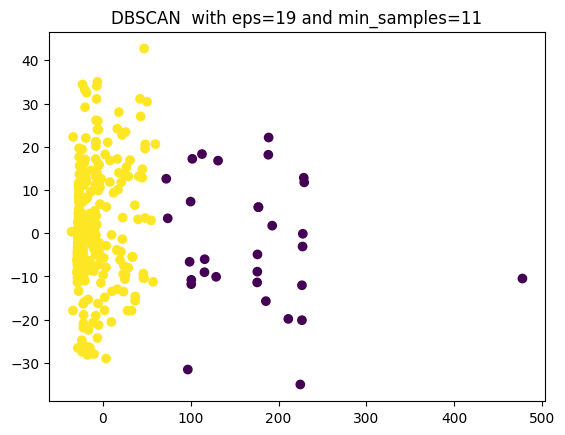

In [116]:
for eps in range(16, 20):
    for mis_s in range (9, 12):
        labels = cluster_data(test_data, algorithm='DBSCAN', eps=eps, min_s=mis_s)
        plt.scatter(test_pca[:, 0], test_pca[:, 1], c=labels)
        plt.title(f"DBSCAN  with eps={eps} and min_samples={mis_s}")
        plt.show()

Looking through the plots we can see that the highest score of 0.827 was achieved using KMeans with 2 clusters, the score of 0.824 was achieved using DBSCAN with eps 19 and 9 min samples (the number of samples in a neighborhood for a point to be considered as a core point) providing 2 clasters of data. This means that our data is very similar within a cluster and dissimilar to other cluster's objects. We can see that one class has higher Fare, Age, SibSp, Sex_Female, Parch and CabinBool features' values, while another has higher Pclass and Sex_Male features. Embarked features differ too. Interesting thing is that one cluster seems like is fully made of values with Pclass feature equal to 1.

With the increase of n_clusters the silhouette score has decreased meaning that data within a cluster started to gain similarity to other clusters' objects.
With our parameters DBSCAN always provided us with two clusters and the silhouette score didn't differ too much between parameters sets.

After this practice, DBSCAN seems more usable method for clusterisation, as it is very flexible and it wasn't confused by outliers on train data as much as KMeans was.